# Imports and pre-processing

In [2]:
import json
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as mp
sns.set_theme()

In [115]:
def get_rolling_avg(series,window):
    out=[]
    for i in range(0,len(series)):
        if i<window:
            if i==0:
                out.append(series[i])
            else:
                out.append(np.mean(series[:i]))
        else:
            out.append(np.mean(series[i-window:i]))
    return out

def create_retention_df(df_data, grp_col, cohort_col):
    # assign cohort based on the month of first proposal
    
    df_sorted = df_data.sort_values([grp_col,'created'])
    df_cohort = df_sorted.groupby(grp_col).agg({'year_month': 'first', 'created': 'first'}).reset_index()
    df_cohort.columns = [grp_col, 'cohort',cohort_col]

    list_cohorts = sorted(df_cohort['cohort'].unique())
    list_cohorts = sorted(set(pd.date_range(start=min(list_cohorts), end=max(list_cohorts), freq='MS').strftime('%Y-%m')))
    retention_periods = {'1m': 1,'3m': 3,'6m': 6,'12m': 12}
    lst_cohort_size = []
    # initialize df_retention_data_raw with one column 'year_month' from df_cohort['cohort'] and then from the list of retention periods [str(cohort + ' - retention - ' + period) for cohort in list_cohorts for period in retention_periods]
    df_retention_data_raw = pd.DataFrame(index=list_cohorts, columns=[f'{cohort} - retention - {period}' for cohort in list_cohorts for period in retention_periods.keys()])
    df_retention_data_raw['year_month'] = list_cohorts

    for cohort in list_cohorts:
        spaces_in_cohort = df_cohort[df_cohort['cohort']==cohort][grp_col].unique()
        count_spaces_in_cohort = len(spaces_in_cohort)
        lst_cohort_size.append(count_spaces_in_cohort)
        cohort_index = list_cohorts.index(cohort)
        # instead of grouping by 'year_month', we need to loop through each month and count the unique spaces that created a proposal in that month + X months
        for period in retention_periods.keys():
            retention_period_num = retention_periods[period]
            # loop through months adjusted to exclude cohort start month, and incomplete retention periods
            for i in range(cohort_index + 1, len(list_cohorts) - retention_period_num):
                retention_window = [m for m in list_cohorts[i:i+retention_period_num]]
                # filter df_proposals_copy to spaces in 'cohort' and months in ('month', 'month'+1, 'month'+2), and count unique spaces
                count = df_data[df_data[grp_col].isin(spaces_in_cohort) & df_data['year_month'].isin(retention_window)][grp_col].nunique()
                # for percent, divide by count of spaces in cohort
                if count_spaces_in_cohort != 0:
                    df_retention_data_raw.loc[list_cohorts[i], str(cohort) + ' - retention - ' + str(period)] = count / count_spaces_in_cohort
                else:
                    df_retention_data_raw.loc[list_cohorts[i], str(cohort) + ' - retention - ' + str(period)] = 0 
    
    return [list_cohorts,lst_cohort_size,df_retention_data_raw]


def make_retention_chart(df_data,list_cohorts,lst_cohort_size, retention_lst, retention_of, retention_doing, savefig = 1, **kwargs):
    # initialize a figure that will have 4 subplots
    ylim = kwargs.get('ylim', 0.5)
    add_title=kwargs.get('add_title', '')
    fig, ax = mp.subplots(5, 1, figsize=(10, 15), sharex=True)
    cnt = 0
    max_cohort = max(lst_cohort_size)
    palette = sns.color_palette("viridis_r", len(list_cohorts))
    # force the first color entry to be grey

    max_width = 4
    # extract all colors from the .jet map

    for cohort in list_cohorts:
        ax[0].plot(df_data['year_month'].values, 100*df_data[str(cohort) + ' - retention - 1m'].values, label=f"Cohort {cohort}", linewidth=max(max_width*(lst_cohort_size[cnt]/max_cohort),0.8), color=palette[cnt], alpha=0.6)
        ax[1].plot(df_data['year_month'].values, 100*df_data[str(cohort) + ' - retention - 3m'].values, label=f"Cohort {cohort}", linewidth=max(max_width*(lst_cohort_size[cnt]/max_cohort),0.8), color=palette[cnt], alpha=0.6)
        ax[2].plot(df_data['year_month'].values, 100*df_data[str(cohort) + ' - retention - 6m'].values, label=f"Cohort {cohort}", linewidth=max(max_width*(lst_cohort_size[cnt]/max_cohort),0.8), color=palette[cnt], alpha=0.6)
        ax[3].plot(df_data['year_month'].values, 100*df_data[str(cohort) + ' - retention - 12m'].values, label=f"Cohort {cohort}", linewidth=max(max_width*(lst_cohort_size[cnt]/max_cohort),0.8), color=palette[cnt], alpha=0.6)
        cnt+=1
    ax[0].plot(np.array(df_data['year_month'][1:]), np.diag(100*df_data.filter(like='1m'), k=-1), color='r', linewidth=2)
    ax[1].plot(np.array(df_data['year_month'][1:]), np.diag(100*df_data.filter(like='3m'), k=-1), color='r', linewidth=2)
    ax[2].plot(np.array(df_data['year_month'][1:]), np.diag(100*df_data.filter(like='6m'), k=-1), color='r', linewidth=2)
    ax[3].plot(np.array(df_data['year_month'][1:]), np.diag(100*df_data.filter(like='12m'), k=-1), color='r', linewidth=2)

    fig.suptitle("Retention of " + add_title + retention_of + " creating " + retention_doing + " by cohort \n (colored = cohorts, red=retention of latest cohort, linewidth ~ cohort size)")
    for i in range(4):
        ax[i].set_ylabel("Retention " + str(retention_lst[i]) + "m (in %)")
        if i<2:
            ax[i].set_ylim(0,ylim)
    #ax[0].legend()

    ax[4].plot(list_cohorts, lst_cohort_size, color='k', linewidth=2)

    ax[4].set_xticklabels(df_data['year_month'], rotation=90)
    ax[4].set_ylabel("Cohort size " + retention_of)

    ignore_last = kwargs.get('ignore_last',False)
    x_min = min(df_data['year_month'])
    if ignore_last:
        x_max = df_data['year_month'].sort_values().iloc[-2]
    else:
        x_max = max(df_data['year_month'])
    for ax in ax:
        ax.set_xlim(x_min, x_max)

    #ax[3].legend()
    fig.tight_layout()
    if savefig>0:
        if add_title=='':
            fig.savefig('retention_' +  retention_of + '_' + retention_doing + '.png', dpi=300)
        else:
            fig.savefig('retention_' + add_title +  retention_of + '_' + retention_doing + '.png', dpi=300)

In [59]:
# exclude testnet networks:
df_networks = pd.read_json('networks.json').transpose().reset_index()
df_networks_exclude = df_networks[df_networks['testnet'] == True].reset_index()
network_map = df_networks.set_index('key')['name'].to_dict()
excluded_networks = df_networks_exclude['chainId'].unique().tolist()
excluded_networks.append(4)  # Exclude network_id 4 (Rinkeby)
excluded_networks.append(3)  # Exclude network_id 3 (Ropsten)
excluded_networks.append(42)  # Exclude network_id 42 (Lukson mainnet)
excluded_networks.append(5553)  # Exclude network_id 5553 (Nahmii testnet)
excluded_networks.append(1071) # Exclude network_id 1071 (ShimmerEVM Testnet Deprecated)
excluded_networks.append(1319) # Exclude network_id 1319 (AITD Network)
excluded_networks.append(148) # Exclude network_id 148 (ShimmerEVM Mainnet)

In [37]:
# df_spaces_1=pd.read_csv('csvs/snapshot-hub-mainnet-09-05-2566-spaces.csv')
df_spaces_2=pd.read_csv("csvs/snapshot-hub-mainnet-2023-10-10-spaces_0.csv")

# what is the earliest date we have data for?
# df_spaces_1['created_at']=pd.to_datetime(df_spaces_1['created_at'], unit='s')
df_spaces_2['created_at']=pd.to_datetime(df_spaces_2['created_at'], unit='s')

# combine df_spaces_1 where created_at is before 2023-05-01 and df_spaces_2 where created_at is after 2023-05-01
# df_spaces_1=df_spaces_1[df_spaces_1['created_at']<=datetime.datetime(2023,5,1)]
# df_spaces_2=df_spaces_2[df_spaces_2['created_at']>datetime.datetime(2023,5,1)]

# df_spaces=pd.concat([df_spaces_1,df_spaces_2]).reset_index(drop=True)

# what is the latest date we have data for?
# df_spaces['created_at'].max()
df_spaces_copy = df_spaces_2.copy()

def extract_network_id_from_string(string):
    data = json.loads(string)
    return int(data['network'])
# Vectorize the extraction of network_id for the common case
df_spaces_copy['network_id'] = df_spaces_copy['settings'].apply(extract_network_id_from_string)

# Handle the special case
df_spaces_copy.loc[15692, 'network_id'] = 1

df_spaces_copy['month'] = df_spaces_copy['created_at'].dt.month
df_spaces_copy['year'] = df_spaces_copy['created_at'].dt.year
df_spaces_copy['year_month'] = df_spaces_copy['year'].astype(str) + '-' + df_spaces_copy['month'].astype(str).str.zfill(2)

# exclude testnets
df_spaces_copy = df_spaces_copy[~df_spaces_copy['network_id'].isin(excluded_networks)]


In [43]:
# for verified spaces
# df_verified = pd.read_csv('csvs/verified-spaces.csv')
#update verified column
# df_spaces_copy.loc[df_spaces_copy.id.isin(df_verified['space_name'].unique()),'verified']=1
# for flagged spaces
# df_flagged = pd.read_csv('csvs/flagged-spaces.csv')
#create flagged column
# df_spaces_copy['flagged'] = df_spaces_copy.id.apply(lambda x: 1 if x in df_flagged['space_name'].unique() else 0)
df_verified = df_spaces_copy[df_spaces_copy['verified']==1]['id'].reset_index().drop(columns=['index']).rename(columns={'id': 'space_name'})
df_flagged = df_spaces_copy[df_spaces_copy['flagged']==1]['id'].reset_index().drop(columns=['index']).rename(columns={'id': 'space_name'})

In [46]:
#df_proposals = pd.read_csv("csvs/snapshot-hub-mainnet-04-05-2566-proposals.csv")
df_proposals = pd.read_csv("csvs/snapshot-hub-mainnet-2023-10-10-proposals_0.csv")

# what is the earliest date we have data for?
df_proposals['created']=pd.to_datetime(df_proposals['created'], unit='s')
df_proposals['created'].min()

# what is the latest date we have data for?
df_proposals['created'].max()
df_proposals_copy = df_proposals.copy()

df_proposals_copy['created'] = pd.to_datetime(df_proposals_copy['created'], unit='s')
df_proposals_copy['month'] = df_proposals_copy['created'].dt.month
df_proposals_copy['year'] = df_proposals_copy['created'].dt.year
df_proposals_copy['year_month'] = df_proposals_copy['year'].astype(str) + '-' + df_proposals_copy['month'].astype(str).str.zfill(2)

# exclude testnets
df_proposals_copy = df_proposals_copy[~df_proposals_copy['network'].isin(excluded_networks)]

# does any space have a proposal on multiple networks? yes!
#df_proposals_copy.groupby(['space']).nunique()['network'].sort_values(ascending=False)

# update verified space column
df_proposals_copy['verified_space'] = df_proposals_copy.space.apply(lambda x: 1 if x in df_verified['space_name'].unique() else 0)
# add flagged space column
df_proposals_copy['flagged_space'] = df_proposals_copy.space.apply(lambda x: 1 if x in df_flagged['space_name'].unique() else 0)

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/4253864954.py:2: DtypeWarning: Columns (6,9,13,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_proposals = pd.read_csv("csvs/snapshot-hub-mainnet-2023-10-10-proposals_0.csv")


In [47]:
# fix data issue by combining df_spaces with df_proposals['created'] to create a proxy "space_created_at" date using the date of the first proposal
df_space_created_proxy = df_proposals_copy[['space', 'created']].groupby('space').min().reset_index()
df_space_created_proxy['month'] = df_space_created_proxy['created'].dt.month
df_space_created_proxy['year'] = df_space_created_proxy['created'].dt.year
df_space_created_proxy['year_month'] = df_space_created_proxy['year'].astype(str) + '-' + df_space_created_proxy['month'].astype(str).str.zfill(2)

# join df_spaces_copy with df_space_created_proxy and take min(proxy date & "space_created_at" date) for each space
df_space_created_combined = df_spaces_copy.merge(df_space_created_proxy, how='outer', left_on='id', right_on='space')
df_space_created_combined['space_name'] = df_space_created_combined['id'].combine_first(df_space_created_combined['space'])
df_space_created_combined['space_created_at'] = df_space_created_combined[['created', 'created_at']].min(skipna=True, axis=1)

df_space_created_combined['month'] = df_space_created_combined['space_created_at'].dt.month
df_space_created_combined['year'] = df_space_created_combined['space_created_at'].dt.year
df_space_created_combined['year_month'] = df_space_created_combined['year'].astype(str) + '-' + df_space_created_combined['month'].astype(str).str.zfill(2)

df_space_created_combined.loc[df_space_created_combined.space_name.isin(df_verified['space_name'].unique()),'verified']=1
df_space_created_combined['flagged'] = df_space_created_combined.id.apply(lambda x: 1 if x in df_flagged['space_name'].unique() else 0)

In [48]:
# df_votes = pd.read_csv('csvs/snapshot-hub-mainnet-21-06-2023-votes-clean.csv', dtype={'created': 'str'})
df_votes = pd.read_csv('csvs/snapshot-hub-mainnet-2023-10-10-votes_0.csv', dtype={'created': 'str'})
df_votes_copy = df_votes.copy()

# drop rows where 'created' is not a date
df_votes_copy = df_votes_copy[df_votes_copy['created'] != 'created']

df_votes_copy['created'] = pd.to_datetime(df_votes_copy['created'], unit='s')
df_votes_copy['month'] = df_votes_copy['created'].dt.month
df_votes_copy['year'] = df_votes_copy['created'].dt.year
df_votes_copy['year_month'] = df_votes_copy['year'].astype(str) + '-' + df_votes_copy['month'].astype(str).str.zfill(2)

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/2275441483.py:2: DtypeWarning: Columns (6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_votes = pd.read_csv('csvs/snapshot-hub-mainnet-2023-10-10-votes_0.csv', dtype={'created': 'str'})
/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/2275441483.py:8: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_votes_copy['created'] = pd.to_datetime(df_votes_copy['created'], unit='s')


In [49]:
# Count the number of proposals per space
proposal_count_by_space = df_proposals_copy['space'].value_counts().reset_index()
proposal_count_by_space.columns = ['space', 'proposal_count']

# Count the number of unique voters per space
unique_voters_by_space = df_votes_copy.groupby('space')['voter'].nunique().reset_index()
unique_voters_by_space.columns = ['space', 'unique_voter_count']

# Merge the counts back to the original spaces dataframe
df_space_created_combined_activity_counts = pd.merge(df_space_created_combined, proposal_count_by_space, how='left', left_on='id', right_on='space')
df_space_created_combined_activity_counts = pd.merge(df_space_created_combined_activity_counts, unique_voters_by_space, how='left', left_on='id', right_on='space')

# Filter spaces with more than 1 proposal and more than 5 unique voters
df_spaces_filtered_by_activity = df_space_created_combined[(df_space_created_combined_activity_counts['proposal_count'] > 1) & (df_space_created_combined_activity_counts['unique_voter_count'] > 1)]
print(len(df_space_created_combined))
print(len(df_spaces_filtered_by_activity))

34466
9768


In [50]:
df_spaces_created_verified = df_spaces_filtered_by_activity[df_spaces_filtered_by_activity['verified'] == 1]
df_spaces_created_unflagged = df_spaces_filtered_by_activity[df_space_created_combined['flagged'] == 0]
df_spaces_created_all = df_spaces_filtered_by_activity[df_space_created_combined['flagged'] == 0]

df_proposals_filtered_by_activity = df_proposals_copy[df_proposals_copy['space'].isin(df_spaces_filtered_by_activity['space'].unique())]
df_proposals_created_verified = df_proposals_copy[df_proposals_copy['verified_space'] == 1]
df_proposals_created_unflagged = df_proposals_copy[df_proposals_copy['flagged_space'] == 0]
df_proposals_created_all = df_proposals_copy

df_votes_created_verified = df_votes_copy.merge(df_spaces_created_verified[['space_name', 'network_id']], left_on='space', right_on='space_name', how='inner')
df_votes_created_unflagged = df_votes_copy.merge(df_spaces_created_unflagged[['space_name', 'network_id']], left_on='space', right_on='space_name', how='inner')
df_votes_created_all = df_votes_copy.merge(df_spaces_filtered_by_activity[['id', 'network_id']], left_on='space', right_on='id', how='left')
df_votes_created_all.rename(columns={'id_x': 'id'}, inplace=True)
df_votes_created_all.rename(columns={'id_y': 'space_name'}, inplace=True)


/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/4044404596.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spaces_created_unflagged = df_spaces_filtered_by_activity[df_space_created_combined['flagged'] == 0]
/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/4044404596.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spaces_created_all = df_spaces_filtered_by_activity[df_space_created_combined['flagged'] == 0]


# Growth

#### New spaces per month by network

In [51]:
target = 'unflagged' #'verified' 'unflagged' 'all'
if target == 'verified':
    df_space_created_target = df_spaces_created_verified
elif target == 'unflagged':
    df_space_created_target = df_spaces_created_unflagged
elif target == 'all':
    df_space_created_target = df_spaces_created_all
else:
    raise ValueError(f"Invalid target value: {target}")

In [52]:
# Aggregate to get monthly counts of spaces created for each network ID
df_spaces_monthly_counts = df_space_created_target.groupby(['network_id','year_month']).count()['id'].reset_index(name='count')
# Calculate month-over-month growth rate of spaces for each network
df_spaces_monthly_counts['growth_rate'] = df_spaces_monthly_counts.groupby('network_id')['count'].pct_change()
# Calculate quarter-over-quarter (every 3 months) growth rate of spaces for each network
df_spaces_monthly_counts['growth_rate_qoq'] = df_spaces_monthly_counts.groupby('network_id')['count'].pct_change(periods=3)
# Determine the share of spaces each network has out of the total for a given month
df_spaces_monthly_counts['share_of_spaces'] = df_spaces_monthly_counts.groupby('year_month')['count'].transform(lambda x: x / x.sum())
# Add columns to use network name besides of id
df_spaces_monthly_counts['network_name'] = [network_map[str(int(lab))] for lab in df_spaces_monthly_counts['network_id']]
# Aggregate to get the total count of spaces created each month across all networks
df_spaces_monthly_total = df_spaces_monthly_counts.groupby(['year_month']).sum()['count'].reset_index()
# Calculate month-over-month growth rate for the total spaces created across all networks
df_spaces_monthly_total['growth_rate'] = df_spaces_monthly_total['count'].pct_change()
# Restructure into each row representing a unique 'year_month', each column a unique 'network_id', and cells 'share_of_spaces'
df_spaces_monthly_counts_pivot_data = df_spaces_monthly_counts.pivot(index='year_month', columns='network_id', values='share_of_spaces')

# Set filter to 0 if all spaces are to be included in analysis
space_share_filter = 0.005
# Find out average 'share_of_spaces' for each network
space_network_means = df_spaces_monthly_counts_pivot_data.apply(lambda x: sum(x.fillna(0)) / len(x), axis=0)
# Find out networks with average share avobe filter
space_filtered_networks = space_network_means[space_network_means > space_share_filter].index.tolist()
# Filter out monthly count data
df_spaces_monthly_counts_filtered = df_spaces_monthly_counts[df_spaces_monthly_counts.network_id.isin(space_filtered_networks)].copy()
# Create an "Other" category
df_other_network = df_spaces_monthly_counts[~df_spaces_monthly_counts.network_id.isin(space_filtered_networks)]
df_other_grouped = df_other_network.groupby('year_month').agg({'count': 'sum','share_of_spaces': 'sum'}).reset_index()
df_other_grouped['network_id'] = 3141592654
df_other_grouped['network_name'] = 'Others'
df_other_grouped['growth_rate'] = df_other_grouped['count'].pct_change()
df_other_grouped['growth_rate_qoq'] = df_other_grouped['count'].pct_change(periods=3)
# Append 'Other' to main DataFrame
df_spaces_monthly_counts_filtered = pd.concat([df_spaces_monthly_counts_filtered,df_other_grouped], ignore_index=True)

# Pivot for shares
space_pivot_shares = df_spaces_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='share_of_spaces')
space_pivot_shares = space_pivot_shares[df_spaces_monthly_counts_filtered.sort_values('network_id')['network_name'].unique()]

# Pivot count
space_pivot_count = df_spaces_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='count')
space_pivot_count = space_pivot_count[df_spaces_monthly_counts_filtered.sort_values('network_id')['network_name'].unique()]
space_pivot_count['Total'] = space_pivot_count.sum(axis=1)
# Pivot MoM growth rate
rolling_avg = 3
space_pivot_growth = df_spaces_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='growth_rate').rolling(rolling_avg).mean()
space_pivot_growth = space_pivot_growth[df_spaces_monthly_counts_filtered.sort_values('network_id')['network_name'].unique()]
space_pivot_growth['Total'] = space_pivot_count['Total'].pct_change().rolling(rolling_avg).mean()


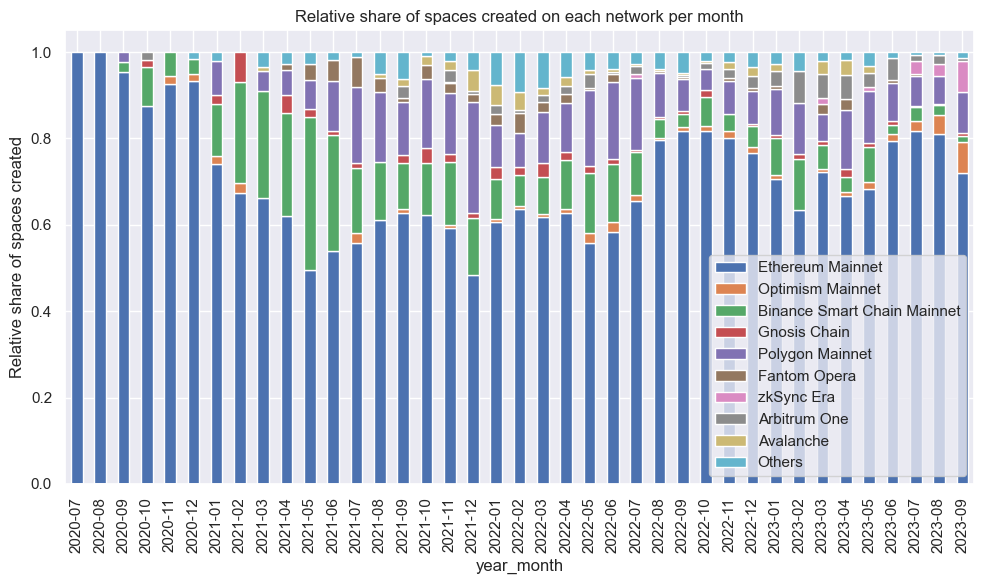

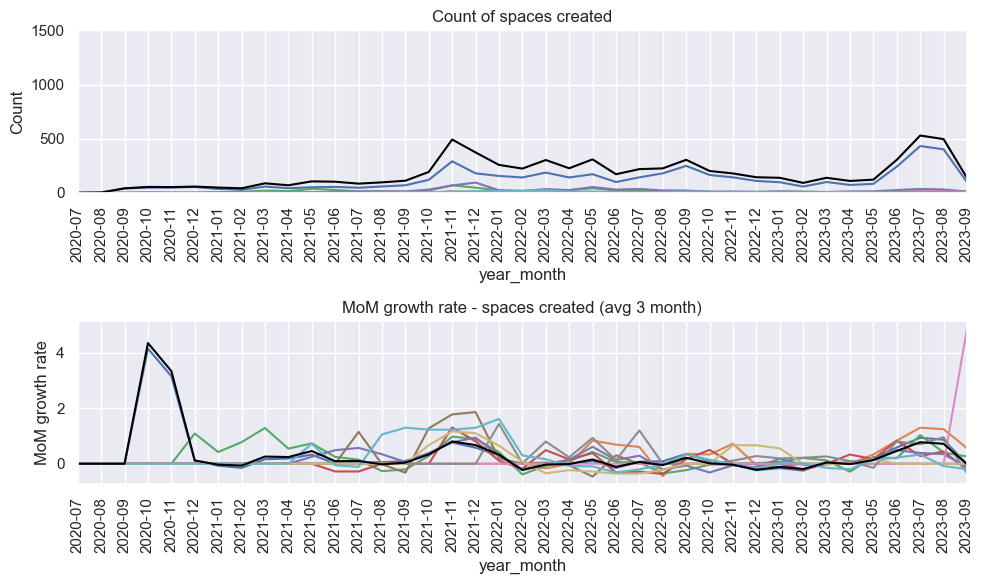

In [55]:
# Monthly Relative Share
#remove last month as it's incomplete
space_pivot_shares = space_pivot_shares.iloc[:-1]
space_pivot_count = space_pivot_count.iloc[:-1]
space_pivot_growth = space_pivot_growth.iloc[:-1]

# Plot
ax = space_pivot_shares.plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Relative share of spaces created')
ax.set_title('Relative share of spaces created on each network per month')
ax.legend(title=None)
fig = ax.get_figure()
fig.tight_layout()

# Monthly Count & MoM Growth Rates

fig, axs = mp.subplots(2, 1, figsize=(10, 6))
# Plot
lines_count = space_pivot_count.fillna(0).plot(ax=axs[0], title="Count of spaces created", ylabel="Count", legend=False)
lines_growth = space_pivot_growth.fillna(0).plot(ax=axs[1], title=f"MoM growth rate - spaces created (avg {rolling_avg} month)", ylabel="MoM growth rate", legend=False)
# Change color of "Total" line to black
lines_count.get_lines()[-1].set_color('black')
lines_growth.get_lines()[-1].set_color('black')
# Adjustments to legend etc
for ax in axs:
    ax.set_xlim(space_pivot_count.index[0], space_pivot_count.index[-1])
    ax.set_xticks(range(len(space_pivot_count.index)))
    ax.set_xticklabels(space_pivot_count.index, rotation=90)
axs[0].set_ylim(0,1500)
fig.tight_layout()

#### New proposals per month by network

In [56]:
target = 'unflagged' #'verified' 'unflagged' 'all'
if target == 'verified':
    df_proposals_target = df_proposals_created_verified
elif target == 'unflagged':
    df_proposals_target = df_proposals_created_unflagged
elif target == 'all':
    df_proposals_target = df_proposals_created_all
else:
    raise ValueError(f"Invalid target value: {target}")

In [93]:
# Fill NaN values with a placeholder value, e.g., -1
df_proposals_created_verified['year'] = df_proposals_created_verified['year'].fillna(-1)
df_proposals_created_verified['month'] = df_proposals_created_verified['month'].fillna(-1)
# Now perform the conversion to int, then to string, and create the 'year_month' column
df_proposals_created_verified['year_month'] = (
    df_proposals_created_verified['year'].astype(int).astype(str) + '-' +
    df_proposals_created_verified['month'].astype(int).astype(str).str.zfill(2)
)
#Replace placeholder 'year_month' values with something else, e.g., 'Unknown'
df_proposals_created_verified['year_month'] = df_proposals_created_verified['year_month'].replace('-1-01', 'Unknown')

# Fill NaN values with a placeholder value, e.g., -1
df_proposals_created_unflagged['year'] = df_proposals_created_unflagged['year'].fillna(-1)
df_proposals_created_unflagged['month'] = df_proposals_created_unflagged['month'].fillna(-1)
# Now perform the conversion to int, then to string, and create the 'year_month' column
df_proposals_created_unflagged['year_month'] = (
    df_proposals_created_unflagged['year'].astype(int).astype(str) + '-' +
    df_proposals_created_unflagged['month'].astype(int).astype(str).str.zfill(2)
)
#Replace placeholder 'year_month' values with something else, e.g., 'Unknown'
df_proposals_created_unflagged['year_month'] = df_proposals_created_unflagged['year_month'].replace('-1-01', 'Unknown')

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/2934541972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proposals_created_verified['year'] = df_proposals_created_verified['year'].fillna(-1)
/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/2934541972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_proposals_created_verified['month'] = df_proposals_created_verified['month'].fillna(-1)
/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/2934541972.py:

In [69]:
# Aggregate to get monthly counts of proposals created for each network
df_proposals_monthly_counts = df_proposals_target.groupby(['network','year_month']).count()['id'].reset_index(name='count')
# Calculate month-over-month growth rate of proposals for each network
df_proposals_monthly_counts['growth_rate'] = df_proposals_monthly_counts.groupby('network')['count'].pct_change()
# Calculate quarter-over-quarter (every 3 months) growth rate of proposals for each network
df_proposals_monthly_counts['growth_rate_qoq'] = df_proposals_monthly_counts.groupby('network')['count'].pct_change(periods=3)
# Determine the share of proposals each network has out of the total for a given month
df_proposals_monthly_counts['share_of_proposals'] = df_proposals_monthly_counts.groupby('year_month')['count'].transform(lambda x: x / x.sum())
# Add columns to use network name besides of id
# df_proposals_monthly_counts['network_name'] = [network_map[str(int(lab))] for lab in df_proposals_monthly_counts['network']]
df_proposals_monthly_counts['network_name'] = df_proposals_monthly_counts['network'].apply(lambda x: network_map.get(str(int(x)), 'Unknown'))
# Aggregate to get the total count of proposals created each month across all networks
df_proposals_monthly_total = df_proposals_monthly_counts.groupby(['year_month']).sum()['count'].reset_index()
# Calculate month-over-month growth rate for the total proposals created across all networks
df_proposals_monthly_total['growth_rate'] = df_proposals_monthly_total['count'].pct_change()
# Restructure into each row representing a unique 'year_month', each column a unique 'network', and cells 'share_of_proposals'
df_proposals_monthly_counts_pivot_data = df_proposals_monthly_counts.pivot(index='year_month', columns='network', values='share_of_proposals')

# Set filter to 0 if all proposals are to be included in analysis
proposal_share_filter = 0.005
# Find out average 'share_of_proposals' for each network
proposal_network_means = df_proposals_monthly_counts_pivot_data.apply(lambda x: sum(x.fillna(0)) / len(x), axis=0)
# Find out networks with average share avobe filter
proposal_filtered_networks = proposal_network_means[proposal_network_means > proposal_share_filter].index.tolist()
# Filter out monthly count data
df_proposals_monthly_counts_filtered = df_proposals_monthly_counts[df_proposals_monthly_counts.network.isin(proposal_filtered_networks)].copy()
# Create an "Other" category
df_other = df_proposals_monthly_counts[~df_proposals_monthly_counts.network.isin(proposal_filtered_networks)]
df_other_grouped = df_other.groupby('year_month').agg({'count': 'sum','share_of_proposals': 'sum'}).reset_index()
df_other_grouped['network'] = 3141592654
df_other_grouped['network_name'] = 'Others'
df_other_grouped['growth_rate'] = df_other_grouped['count'].pct_change()
df_other_grouped['growth_rate_qoq'] = df_other_grouped['count'].pct_change(periods=3)
# # Append 'Other' to main DataFrame & re-calculate 'share_of_proposals'
df_proposals_monthly_counts_filtered = pd.concat([df_proposals_monthly_counts_filtered,df_other_grouped], ignore_index=True)

# Pivot for shares
proposal_pivot_shares = df_proposals_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='share_of_proposals')
proposal_pivot_shares = proposal_pivot_shares[df_proposals_monthly_counts_filtered.sort_values('network')['network_name'].unique()]

# Pivot count
proposal_pivot_count = df_proposals_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='count')
proposal_pivot_count = proposal_pivot_count[df_proposals_monthly_counts_filtered.sort_values('network')['network_name'].unique()]
proposal_pivot_count['Total'] = proposal_pivot_count.sum(axis=1)
# Pivot MoM growth rate
rolling_avg = 3
proposal_pivot_growth = df_proposals_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='growth_rate').rolling(rolling_avg).mean()
proposal_pivot_growth = proposal_pivot_growth[df_proposals_monthly_counts_filtered.sort_values('network')['network_name'].unique()]
proposal_pivot_growth['Total'] = proposal_pivot_count['Total'].pct_change().rolling(rolling_avg).mean()

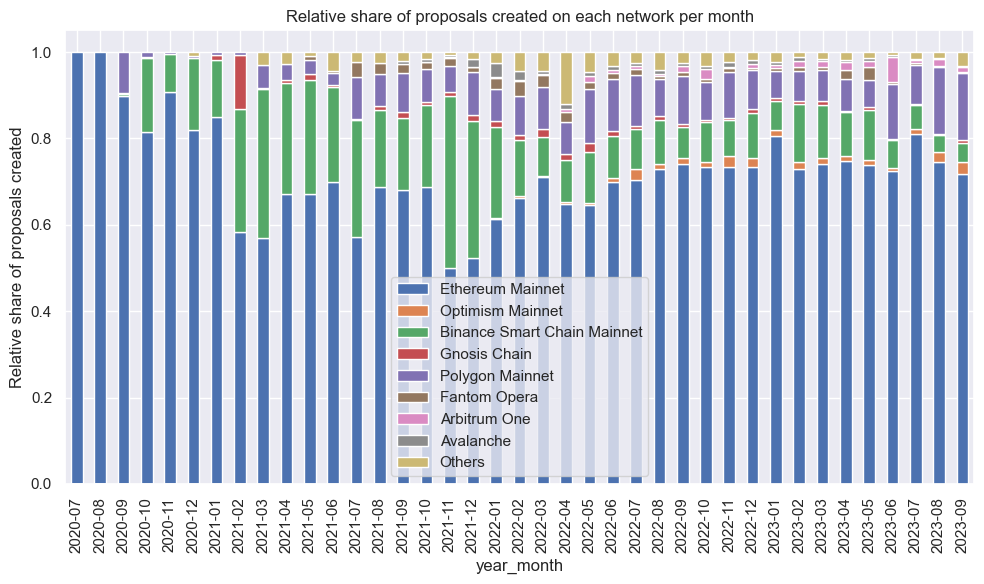

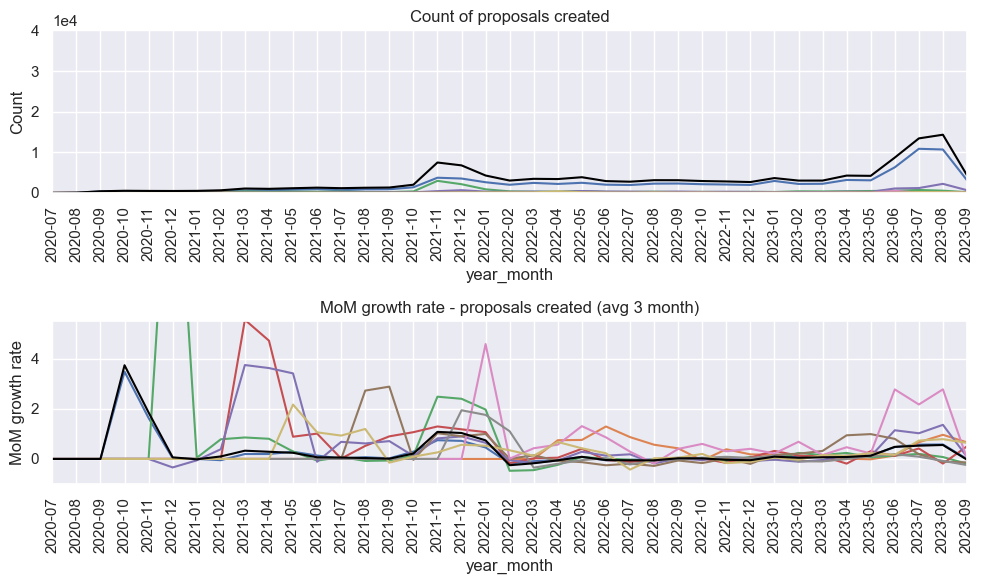

In [71]:
# Monthly Relative Share
#remove last month as it's incomplete
proposal_pivot_shares = proposal_pivot_shares.iloc[:-1]
proposal_pivot_count = proposal_pivot_count.iloc[:-1]
proposal_pivot_growth = proposal_pivot_growth.iloc[:-1]

ax = proposal_pivot_shares.plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Relative share of proposals created')
ax.set_title('Relative share of proposals created on each network per month')
ax.legend(title=None)
fig = ax.get_figure()
fig.tight_layout()

# Monthly Count & MoM Growth Rates

fig, axs = mp.subplots(2, 1, figsize=(10, 6))

lines_count = proposal_pivot_count.fillna(0).plot(ax=axs[0], title="Count of proposals created", ylabel="Count", legend=False)
lines_growth = proposal_pivot_growth.fillna(0).plot(ax=axs[1], title=f"MoM growth rate - proposals created (avg {rolling_avg} month)", ylabel="MoM growth rate", legend=False)

# Change color of "Total" line to black
lines_count.get_lines()[-1].set_color('black')
lines_growth.get_lines()[-1].set_color('black')

# Adjustments to legend etc
for ax in axs:
    ax.set_xlim(proposal_pivot_count.index[0], proposal_pivot_count.index[-1])
    ax.set_xticks(range(len(proposal_pivot_count.index)))
    ax.set_xticklabels(proposal_pivot_count.index, rotation=90)
axs[1].set_ylim(-1,5.5)
axs[0].set_ylim(0,40000)
axs[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
fig.tight_layout()

#### New votes per month by network

In [72]:
target = 'unflagged' #'verified' 'unflagged' 'all'
if target == 'verified':
    df_votes_target = df_votes_created_verified
elif target == 'unflagged':
    df_votes_target = df_votes_created_unflagged
elif target == 'all':
    df_votes_target = df_votes_created_all
else:
    raise ValueError(f"Invalid target value: {target}")
# df_votes_target = df_votes_target[~df_votes_target['network_id'].isnull()] # 0 rows for join with df_spaces
# df_votes_target = df_votes_target[~df_votes_target['network_id'].isin(excluded_networks)] # if merged with df_spaces

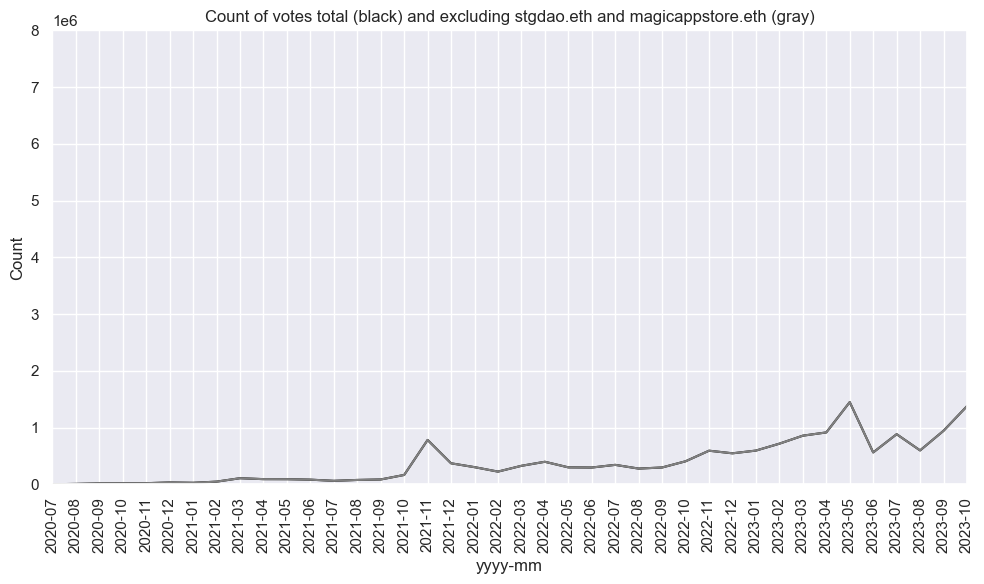

In [75]:
df_total = df_votes_target.groupby(['year_month']).agg({'id':'count'}).reset_index()
df_total = df_total.rename(columns={'id': 'count_total'})
df_special = df_votes_target[df_votes_target.space.isin(['stgdao.eth', 'magicappstore.eth'])].groupby(['year_month']).agg({'id':'count'}).reset_index()
df_special = df_special.rename(columns={'id': 'count_special'})
df_merge = df_total.merge(df_special, on='year_month', how='left', suffixes=('_total', '_special'))
df_merge['count_remainder'] = df_merge['count_total'] - df_merge['count_special'].fillna(0)


fig, axs = mp.subplots(1, 1, figsize=(10, 6))
lines_count = df_merge.plot(x='year_month', y=['count_total', 'count_remainder'], ax=axs, title="Count of votes total (black) and excluding stgdao.eth and magicappstore.eth (gray)", ylabel="Count", legend=False)
# Change color
lines_count.get_lines()[0].set_color('black')
lines_count.get_lines()[1].set_color('gray')
# Adjustments to legend, labels, etc
axs.set_xlim(df_merge['year_month'].iloc[0], df_merge['year_month'].iloc[-1])
axs.set_ylim(0, 8000000)
axs.set_xticks(range(len(df_merge['year_month'])))
axs.set_xticklabels(df_merge['year_month'], rotation=90)
axs.set_xlabel("yyyy-mm")
axs.set_ylabel("Count")

fig.tight_layout()

In [73]:
excluded_spaces = ['stgdao.eth', 'magicappstore.eth']
df_votes_target = df_votes_target[~df_votes_target['space'].isin(excluded_spaces)]

df_votes_monthly_counts = df_votes_target.groupby(['network_id','year_month']).count()['id'].reset_index(name='count')
df_votes_monthly_counts['growth_rate'] = df_votes_monthly_counts.groupby('network_id')['count'].pct_change()
df_votes_monthly_counts['share_of_votes'] = df_votes_monthly_counts.groupby('year_month')['count'].transform(lambda x: x / x.sum())
# Add columns to use network name besides of id
df_votes_monthly_counts['network_name'] = [network_map[str(int(lab))] for lab in df_votes_monthly_counts['network_id']]
# df_votes_monthly_total = df_votes_copy.groupby('year_month').count()['id_x'].reset_index(name='count')
df_votes_monthly_total = df_votes_monthly_counts.groupby(['year_month']).sum()['count'].reset_index()
df_votes_monthly_total['growth_rate'] = df_votes_monthly_total['count'].pct_change()
df_votes_monthly_counts_pivot_data = df_votes_monthly_counts.pivot(index='year_month', columns='network_id', values='share_of_votes')

# Set filter to 0 if all spaces are to be included in analysis
votes_share_filter = 0.005
# Find out average 'share_of_spaces' for each network
votes_network_means = df_votes_monthly_counts_pivot_data.apply(lambda x: sum(x.fillna(0)) / len(x), axis=0)
# Find out networks with average share avobe filter
votes_filtered_networks = votes_network_means[votes_network_means > votes_share_filter].index.tolist()
# Filter out monthly count data
df_votes_monthly_counts_filtered = df_votes_monthly_counts[df_votes_monthly_counts.network_id.isin(votes_filtered_networks)].copy()

# Create an "Other" category
df_other = df_votes_monthly_counts[~df_votes_monthly_counts.network_id.isin(votes_filtered_networks)]
df_other_grouped = df_other.groupby('year_month').agg({'count': 'sum','share_of_votes': 'sum'}).reset_index()
df_other_grouped['network_id'] = 3141592654
df_other_grouped['network_name'] = 'Others'
df_other_grouped['growth_rate'] = df_other_grouped['count'].pct_change()
df_other_grouped['growth_rate_qoq'] = df_other_grouped['count'].pct_change(periods=3)
# Append 'Other' to main DataFrame & re-calculate 'share_of_proposals'
df_votes_monthly_counts_filtered = pd.concat([df_votes_monthly_counts_filtered,df_other_grouped], ignore_index=True)

# Pivot for shares
votes_pivot_shares = df_votes_monthly_counts_filtered.pivot(index='year_month', columns='network_name', values='share_of_votes')
votes_pivot_shares = votes_pivot_shares[df_votes_monthly_counts_filtered.sort_values('network_id')['network_name'].unique()]

# Pivot count
vote_pivot_count = df_votes_monthly_counts_filtered.pivot(index='year_month', columns='network_id', values='count')
vote_pivot_count = vote_pivot_count[df_votes_monthly_counts_filtered.sort_values('network_id')['network_id'].unique()]
vote_pivot_count['Total'] = vote_pivot_count.sum(axis=1)

# Pivot MoM growth rate
rolling_avg = 3
vote_pivot_growth = df_votes_monthly_counts_filtered.pivot(index='year_month', columns='network_id', values='growth_rate').rolling(rolling_avg).mean()
vote_pivot_growth = vote_pivot_growth[df_votes_monthly_counts_filtered.sort_values('network_id')['network_id'].unique()]
vote_pivot_growth['Total'] = vote_pivot_count['Total'].pct_change().rolling(rolling_avg).mean()

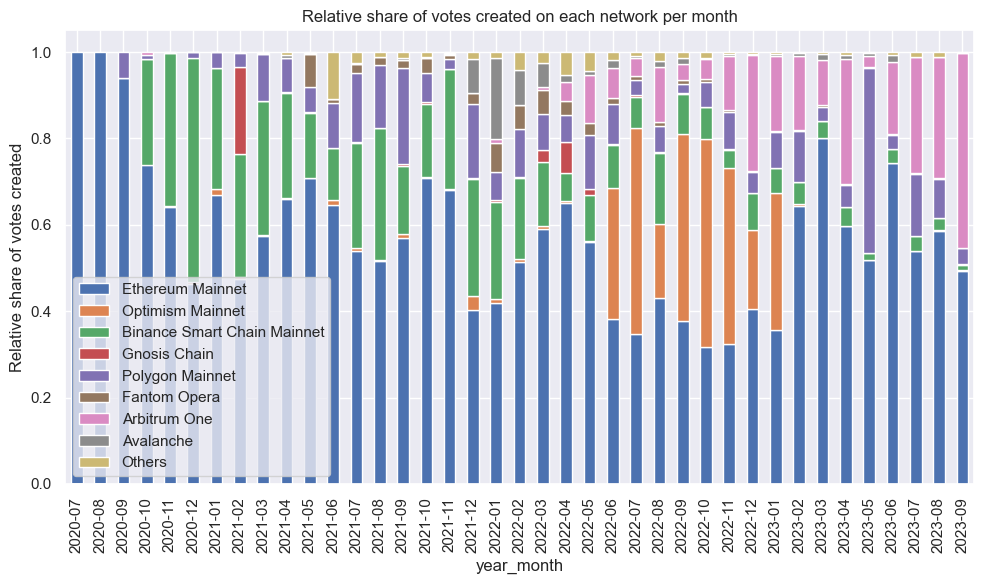

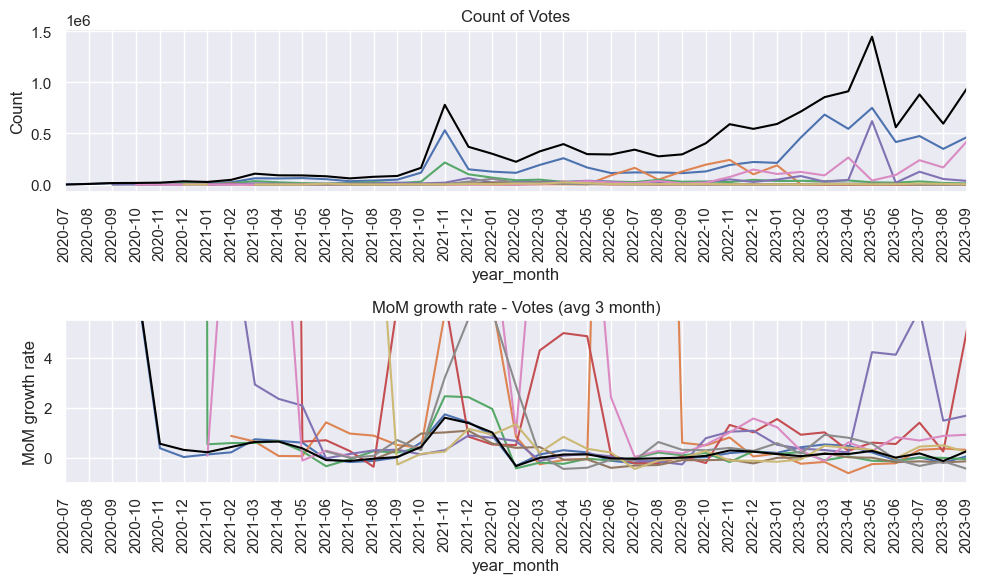

In [76]:
# Monthly Relative Share
votes_pivot_shares = votes_pivot_shares.iloc[:-1]
vote_pivot_count = vote_pivot_count.iloc[:-1]
vote_pivot_growth = vote_pivot_growth.iloc[:-1]

ax = votes_pivot_shares.plot(kind='bar', stacked=True, figsize=(10,6))
ax.set_ylabel('Relative share of votes created')
ax.set_title('Relative share of votes created on each network per month')
ax.legend(title=None)
fig = ax.get_figure()
fig.tight_layout()

# Counts

fig, axs = mp.subplots(2, 1, figsize=(10, 6))

lines_count = vote_pivot_count.plot(ax=axs[0], title="Count of Votes", ylabel="Count", legend=False)
lines_growth = vote_pivot_growth.plot(ax=axs[1], title=f"MoM growth rate - Votes (avg {rolling_avg} month)", ylabel="MoM growth rate", legend=False)

# Change color of "Total" line to black
lines_count.get_lines()[-1].set_color('black')
lines_growth.get_lines()[-1].set_color('black')

# Adjustments to legend etc
for ax in axs:
    ax.set_xlim(vote_pivot_count.index[0], vote_pivot_count.index[-1])
    ax.set_xticks(range(len(vote_pivot_count.index)))
    ax.set_xticklabels(vote_pivot_count.index, rotation=90)
axs[1].set_ylim(-1, 5.5)

fig.tight_layout()

# Engagement

In [77]:
excluded_spaces = ['stgdao.eth', 'magicappstore.eth']
df_votes_target_verified = df_votes_created_verified[~df_votes_created_verified['space'].isin(excluded_spaces)]
df_votes_target_unflagged = df_votes_created_unflagged[~df_votes_created_unflagged['space'].isin(excluded_spaces)]

#### Average snapshot votes per unique voter per month

In [78]:
rolling_avg = 3
# For Unflagged
df_count_votes_per_voter_monthly_unflagged = df_votes_target_unflagged.groupby(['year_month','voter']).count()['id']
df_voter_stats_unflagged = df_count_votes_per_voter_monthly_unflagged.groupby(['year_month']).agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.95), lambda x: x.quantile(1)]).reset_index()
df_voter_stats_unflagged.columns = ['year_month', 'avg', 'median', '25_quantile', '75_quantile', '95_quantile', 'max']
df_voter_stats_unflagged['growth_rate'] = df_voter_stats_unflagged['avg'].pct_change()
df_voter_stats_unflagged['rolling_avg'] = df_voter_stats_unflagged['avg'].rolling(rolling_avg).mean()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


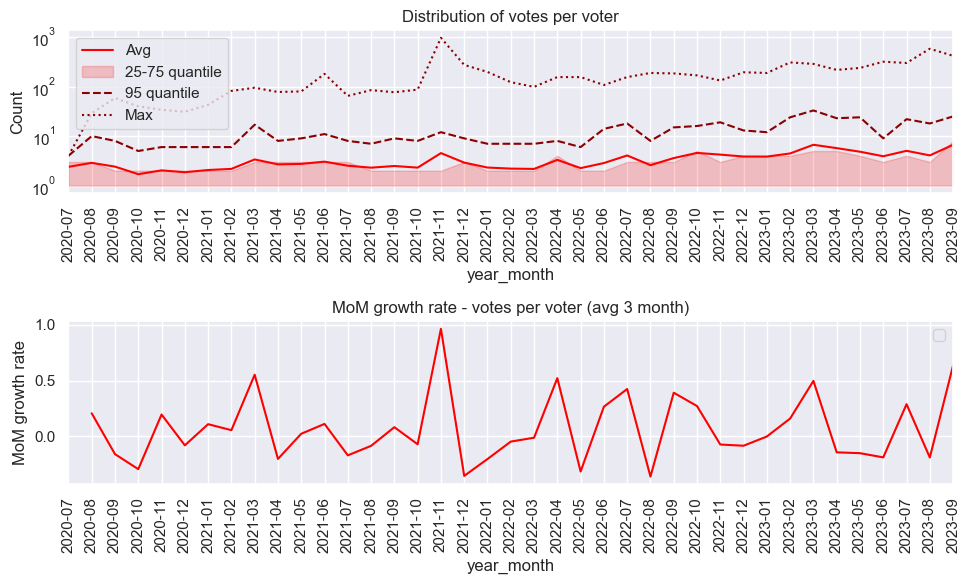

In [82]:
fig, axs = mp.subplots(2, 1, figsize=(10, 6))
df_voter_stats_unflagged = df_voter_stats_unflagged.iloc[:-1]

# Plot - Unflagged (Red)
axs[0].plot(df_voter_stats_unflagged['year_month'], df_voter_stats_unflagged['avg'], color='red', label='Avg')
axs[0].fill_between(df_voter_stats_unflagged['year_month'], df_voter_stats_unflagged['25_quantile'], df_voter_stats_unflagged['75_quantile'], color='red', alpha=0.2, label='25-75 quantile')
axs[0].plot(df_voter_stats_unflagged['year_month'], df_voter_stats_unflagged['95_quantile'], '--', color='darkred', label='95 quantile')
axs[0].plot(df_voter_stats_unflagged['year_month'], df_voter_stats_unflagged['max'], ':', color='darkred', label='Max')
axs[0].set_title("Distribution of votes per voter")
axs[0].set_ylabel("Count")

axs[1].plot(df_voter_stats_unflagged['year_month'], df_voter_stats_unflagged['growth_rate'], color='red')
axs[1].set_title(f"MoM growth rate - votes per voter (avg {rolling_avg} month)")
axs[1].set_ylabel("MoM growth rate")

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])

# Adjustments to legend, labels, etc.
for ax in axs:
    ax.set_xticks(range(len(df_voter_stats_unflagged['year_month'])))
    ax.set_xticklabels(df_voter_stats_unflagged['year_month'], rotation=90)
    ax.set_xlabel("year_month")
    ax.set_xlim(x_min,x_max)
    ax.legend()
# axs[0].set_ylim(0,20)
axs[0].set_yscale("log")
fig.tight_layout()


#### Average snapshot votes per space per month

In [83]:
rolling_avg = 3
# For Unflagged
df_count_votes_per_space_monthly_unflagged = df_votes_target_unflagged.groupby(['year_month','space']).count()['id']
df_space_stats_unflagged = df_count_votes_per_space_monthly_unflagged.groupby(['year_month']).agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.95), lambda x: x.quantile(0.99)]).reset_index()
df_space_stats_unflagged.columns = ['year_month', 'avg', 'median', '25_quantile', '75_quantile', '95_quantile', 'max']
df_space_stats_unflagged['growth_rate'] = df_space_stats_unflagged['avg'].pct_change()
df_space_stats_unflagged['rolling_avg'] = df_space_stats_unflagged['avg'].rolling(rolling_avg).mean()

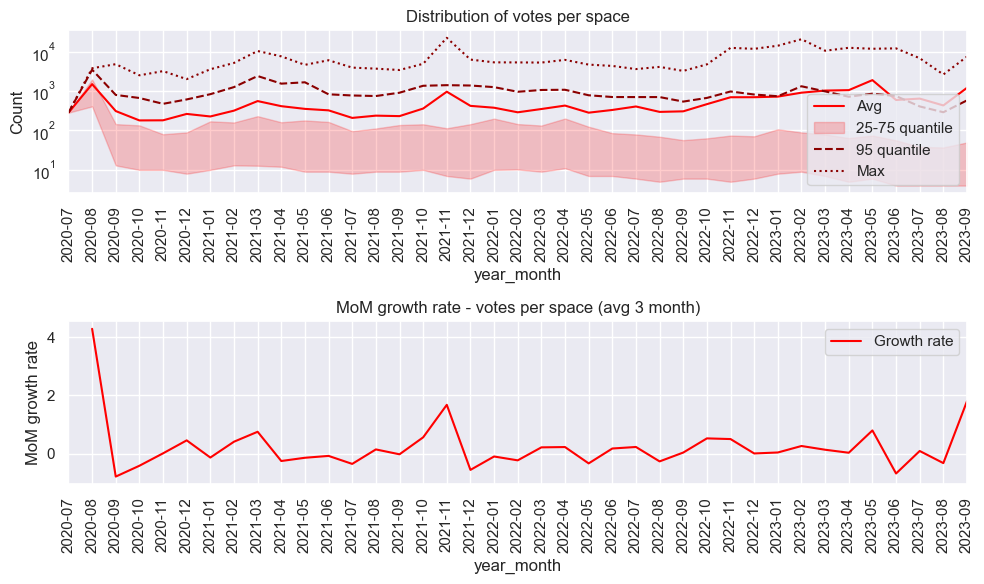

In [84]:
fig, axs = mp.subplots(2, 1, figsize=(10, 6))
df_space_stats_unflagged = df_space_stats_unflagged.iloc[:-1]

# Plot - Unflagged (Red)
axs[0].plot(df_space_stats_unflagged['year_month'], df_space_stats_unflagged['avg'], color='red', label='Avg')
axs[0].fill_between(df_space_stats_unflagged['year_month'], df_space_stats_unflagged['25_quantile'], df_space_stats_unflagged['75_quantile'], color='red', alpha=0.2, label='25-75 quantile')
axs[0].plot(df_space_stats_unflagged['year_month'], df_space_stats_unflagged['95_quantile'], '--', color='darkred', label='95 quantile')
axs[0].plot(df_space_stats_unflagged['year_month'], df_space_stats_unflagged['max'], ':', color='darkred', label='Max')
axs[0].set_title("Distribution of votes per space")
axs[0].set_ylabel("Count")

axs[1].plot(df_space_stats_unflagged['year_month'], df_space_stats_unflagged['growth_rate'], color='red', label='Growth rate')
axs[1].set_title(f"MoM growth rate - votes per space (avg {rolling_avg} month)")
axs[1].set_ylabel("MoM growth rate")

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])

# Adjustments to legend, labels, etc.
for ax in axs:
    ax.set_xticks(range(len(df_space_stats_unflagged['year_month'])))
    ax.set_xticklabels(df_space_stats_unflagged['year_month'], rotation=90)
    ax.set_xlabel("year_month")
    ax.set_xlim(x_min,x_max)
    ax.legend()
axs[0].set_yscale("log")
fig.tight_layout()


#### Average snapshot proposals per space per month

In [85]:
rolling_avg = 3
# For Unflagged
df_count_proposals_per_space_monthly_unflagged = df_proposals_created_unflagged.groupby(['year_month','space']).count()['id']
df_proposal_space_stats_unflagged = df_count_proposals_per_space_monthly_unflagged.groupby(['year_month']).agg(['mean', 'median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), lambda x: x.quantile(0.95), lambda x: x.quantile(0.99)]).reset_index()
df_proposal_space_stats_unflagged.columns = ['year_month', 'avg', 'median', '25_quantile', '75_quantile', '95_quantile', 'max']
df_proposal_space_stats_unflagged['growth_rate'] = df_proposal_space_stats_unflagged['avg'].pct_change()
df_proposal_space_stats_unflagged['rolling_avg'] = df_proposal_space_stats_unflagged['avg'].rolling(rolling_avg).mean()

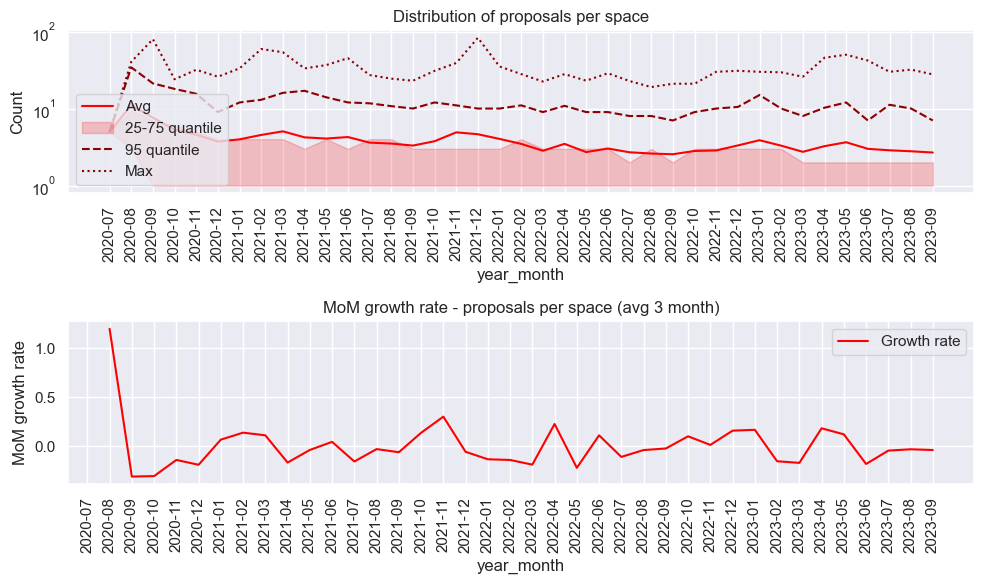

In [86]:
fig, axs = mp.subplots(2, 1, figsize=(10, 6))
df_proposal_space_stats_unflagged = df_proposal_space_stats_unflagged.iloc[:-1]

# Plot - Unflagged (Red)
axs[0].plot(df_proposal_space_stats_unflagged['year_month'], df_proposal_space_stats_unflagged['avg'], color='red', label='Avg')
axs[0].fill_between(df_proposal_space_stats_unflagged['year_month'], df_proposal_space_stats_unflagged['25_quantile'], df_proposal_space_stats_unflagged['75_quantile'], color='red', alpha=0.2, label='25-75 quantile')
axs[0].plot(df_proposal_space_stats_unflagged['year_month'], df_proposal_space_stats_unflagged['95_quantile'], '--', color='darkred', label='95 quantile')
axs[0].plot(df_proposal_space_stats_unflagged['year_month'], df_proposal_space_stats_unflagged['max'], ':', color='darkred', label='Max')
axs[0].set_title("Distribution of proposals per space")
axs[0].set_ylabel("Count")

axs[1].plot(df_proposal_space_stats_unflagged['year_month'], df_proposal_space_stats_unflagged['growth_rate'], color='red', label='Growth rate')
axs[1].set_title(f"MoM growth rate - proposals per space (avg {rolling_avg} month)")
axs[1].set_ylabel("MoM growth rate")

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])

# Adjustments to legend, labels, etc.
for ax in axs:
    ax.set_xticks(range(len(df_proposal_space_stats_unflagged['year_month'])))
    ax.set_xticklabels(df_proposal_space_stats_unflagged['year_month'], rotation=90)
    ax.set_xlabel("year_month")
    # ax.set_xlim(x_min,x_max)
    ax.legend()
axs[0].set_yscale("log")
fig.tight_layout()


#### How many spaces post at least one governance proposal per month?

In [95]:
# count of Spaces with a proposal each month
df_unique_spaces_with_proposal_unflagged = df_proposals_created_unflagged.groupby(['year_month'])['space'].nunique().reset_index(name='count')
df_unique_spaces_with_proposal_unflagged['growth_rate'] = df_unique_spaces_with_proposal_unflagged['count'].pct_change()

df_unique_spaces_with_proposal_verified = df_proposals_created_verified.groupby(['year_month'])['space'].nunique().reset_index(name='count')
df_unique_spaces_with_proposal_verified['growth_rate'] = df_unique_spaces_with_proposal_verified['count'].pct_change()

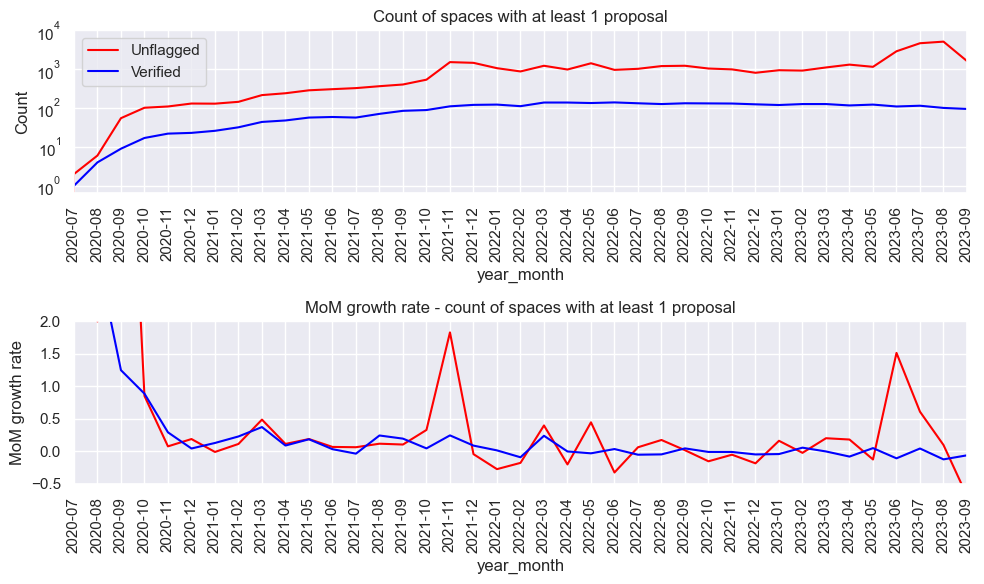

In [100]:
fig, axs = mp.subplots(2, 1, figsize=(10, 6))

# Line plot for Count of Spaces (Unflagged)
axs[0].plot(np.array(df_unique_spaces_with_proposal_unflagged['year_month']), 
            np.array(df_unique_spaces_with_proposal_unflagged['count']), color='red', label='Unflagged')

# Line plot for Count of Spaces (Verified)
axs[0].plot(np.array(df_unique_spaces_with_proposal_verified['year_month']), 
            np.array(df_unique_spaces_with_proposal_verified['count']), color='blue', label='Verified')

axs[0].set_title("Count of spaces with at least 1 proposal")
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
# axs[0].set_ylim(0, 3000)
axs[0].legend()
axs[0].set_yscale("log")
axs[0].set_ylabel("Count")
axs[0].set_xlabel("year_month")
ticks = np.logspace(np.log10(1), np.log10(10000), num=5)
axs[0].set_yticks(ticks)

# Line plot for MoM Growth Rate (Unflagged)
axs[1].plot(np.array(df_unique_spaces_with_proposal_unflagged['year_month']), 
            np.array(df_unique_spaces_with_proposal_unflagged['growth_rate']), color='red', label='Unflagged')

# Line plot for MoM Growth Rate (Verified)
axs[1].plot(np.array(df_unique_spaces_with_proposal_verified['year_month']), 
            np.array(df_unique_spaces_with_proposal_verified['growth_rate']), color='blue', label='Verified')

axs[1].set_title("MoM growth rate - count of spaces with at least 1 proposal")
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[1].set_ylim(-0.5, 2)
axs[1].set_ylabel("MoM growth rate")
axs[1].set_xlabel("year_month")

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])
for ax in axs:
    ax.set_xlim(x_min, x_max)

fig.tight_layout()


#### Amount of unique users voting per month

In [101]:
df_unique_users_with_votes_monthly_verified = df_votes_target_verified.groupby(['year_month'])['voter'].nunique().reset_index(name='count')
df_unique_users_with_votes_monthly_verified['growth_rate'] = df_unique_users_with_votes_monthly_verified['count'].pct_change()

df_unique_users_with_votes_monthly_unflagged = df_votes_target_unflagged.groupby(['year_month'])['voter'].nunique().reset_index(name='count')
df_unique_users_with_votes_monthly_unflagged['growth_rate'] = df_unique_users_with_votes_monthly_unflagged['count'].pct_change()

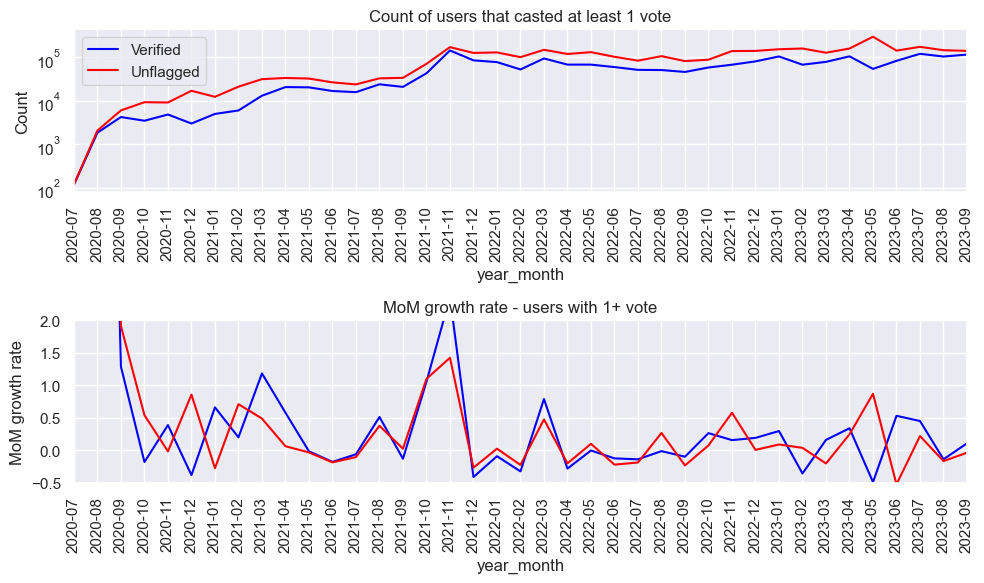

In [102]:
# Initialize the figure and axis objects
fig, axs = mp.subplots(2, 1, figsize=(10, 6))

# Plotting for Count of Users (Verified)
axs[0].plot(df_unique_users_with_votes_monthly_verified['year_month'], 
            df_unique_users_with_votes_monthly_verified['count'], color='blue', label='Verified')

# Plotting for Count of Users (Unflagged)
axs[0].plot(df_unique_users_with_votes_monthly_unflagged['year_month'], 
            df_unique_users_with_votes_monthly_unflagged['count'], color='red', label='Unflagged')

# Setting title and labels for the first subplot
axs[0].set_title("Count of users that casted at least 1 vote")
axs[0].set_xlabel("year_month")
axs[0].set_ylabel("Count")
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
axs[0].legend()
axs[0].set_yscale("log")


# Plotting for MoM Growth Rate (Verified)
axs[1].plot(df_unique_users_with_votes_monthly_verified['year_month'], 
            df_unique_users_with_votes_monthly_verified['growth_rate'], color='blue', label='Verified')

# Plotting for MoM Growth Rate (Unflagged)
axs[1].plot(df_unique_users_with_votes_monthly_unflagged['year_month'], 
            df_unique_users_with_votes_monthly_unflagged['growth_rate'], color='red', label='Unflagged')

# Setting title and labels for the second subplot
axs[1].set_title("MoM growth rate - users with 1+ vote")
axs[1].set_xlabel("year_month")
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[1].set_ylim(-0.5, 2)
axs[1].set_ylabel("MoM growth rate")

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])
for ax in axs:
    ax.set_xlim(x_min, x_max)

# Final layout adjustment
fig.tight_layout()

#### Amount of unique users creating proposals per month

In [103]:
df_unique_users_with_proposals_monthly_verified = df_proposals_created_verified.groupby(['year_month'])['author'].nunique().reset_index(name='count')
df_unique_users_with_proposals_monthly_verified['growth_rate'] = df_unique_users_with_proposals_monthly_verified['count'].pct_change()

df_unique_users_with_proposals_monthly_unflagged = df_proposals_created_unflagged.groupby(['year_month'])['author'].nunique().reset_index(name='count')
df_unique_users_with_proposals_monthly_unflagged['growth_rate'] = df_unique_users_with_proposals_monthly_unflagged['count'].pct_change()

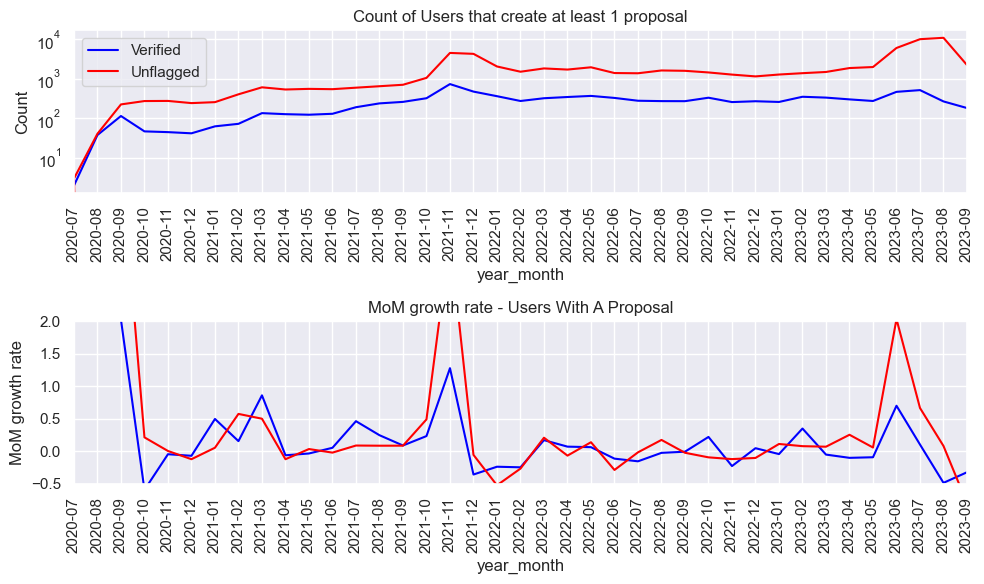

In [104]:
# Initialize the figure and axis objects
fig, axs = mp.subplots(2, 1, figsize=(10, 6))

# Plotting for Count of Users (Verified)
axs[0].plot(df_unique_users_with_proposals_monthly_verified['year_month'], 
            df_unique_users_with_proposals_monthly_verified['count'], color='blue', label='Verified')

# Plotting for Count of Users (Unflagged)
axs[0].plot(df_unique_users_with_proposals_monthly_unflagged['year_month'], 
            df_unique_users_with_proposals_monthly_unflagged['count'], color='red', label='Unflagged')

# Setting title and labels for the first subplot
axs[0].set_title("Count of Users that create at least 1 proposal")
axs[0].set_xlabel("year_month")
axs[0].set_ylabel("Count")
for tick in axs[0].get_xticklabels():
    tick.set_rotation(90)
axs[0].set_yscale("log")
axs[0].legend()

# Plotting for MoM Growth Rate (Verified)
axs[1].plot(df_unique_users_with_proposals_monthly_verified['year_month'], 
            df_unique_users_with_proposals_monthly_verified['growth_rate'], color='blue', label='Verified')

# Plotting for MoM Growth Rate (Unflagged)
axs[1].plot(df_unique_users_with_proposals_monthly_unflagged['year_month'], 
            df_unique_users_with_proposals_monthly_unflagged['growth_rate'], color='red', label='Unflagged')

# Setting title and labels for the second subplot
axs[1].set_title("MoM growth rate - Users With A Proposal")
axs[1].set_xlabel("year_month")
axs[1].set_ylabel("MoM growth rate")
for tick in axs[1].get_xticklabels():
    tick.set_rotation(90)
axs[1].set_ylim(-0.5, 2)

x_min = min(df_voter_stats_unflagged['year_month'])
x_max = max(df_voter_stats_unflagged['year_month'])
for ax in axs:
    ax.set_xlim(x_min, x_max)

# Final layout adjustment
fig.tight_layout()


# Retention

#### NOTES ON RETENTION METRICS
Assign spaces to a cohort based on which month it created it's first proposal.

example 1: 100 spaces create their first proposal in January (January cohort). 30D retention:
- > percent of the jan cohort that created a proposal in February
- > percent of the jan cohort that created a proposal in March
- > percent of the jan cohort that created a proposal in April


example 2: same jan cohort. 90D retention:
- > percent of the jan cohort that created a proposal in Feb/Mar/Apr
- > Mar/Apr/May
- > Apr/May/Jun

### Implementation

Cohorts:
- Monthly: Jan, Feb, Mar...

Retention metrics:
- 30D, 90D, 180D, 360D

Steps:
- x1. Assign cohorts to spaces by identifying the month of their first proposal
- x2. Determine which spaces returned in which months
- x3. For cohort X:
  - 30D Retention: for cohort X, which spaces returned within the next month window (i.e. the next month)? within the 1m window shifted out 1m? ...
  - 90D Retention: for cohort X, which spaces returned within the next 60D (or 3m) window? within the 3m window shifted out 1m? ...
  - 180D Retention: for cohort X, which spaces returned within the next 180D (or 9m) window? within the 9m window shiftet out 1m? ...
  - 360D ...

In [105]:
target = 'verified' #'verified' 'unflagged' 'all'
if target == 'verified':
    df_proposals_target = df_proposals_created_verified
elif target == 'unflagged':
    df_proposals_target = df_proposals_created_unflagged
elif target == 'all':
    df_proposals_target = df_proposals_created_all
else:
    raise ValueError(f"Invalid target value: {target}")

In [ ]:
[list_cohorts_voters_verified,lst_cohort_size_voters_verified,df_retention_voters_verified] = create_retention_df(df_votes_target_verified,grp_col = 'voter',cohort_col='first_proposal')
retention_lst = [1,3,6,12]


/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


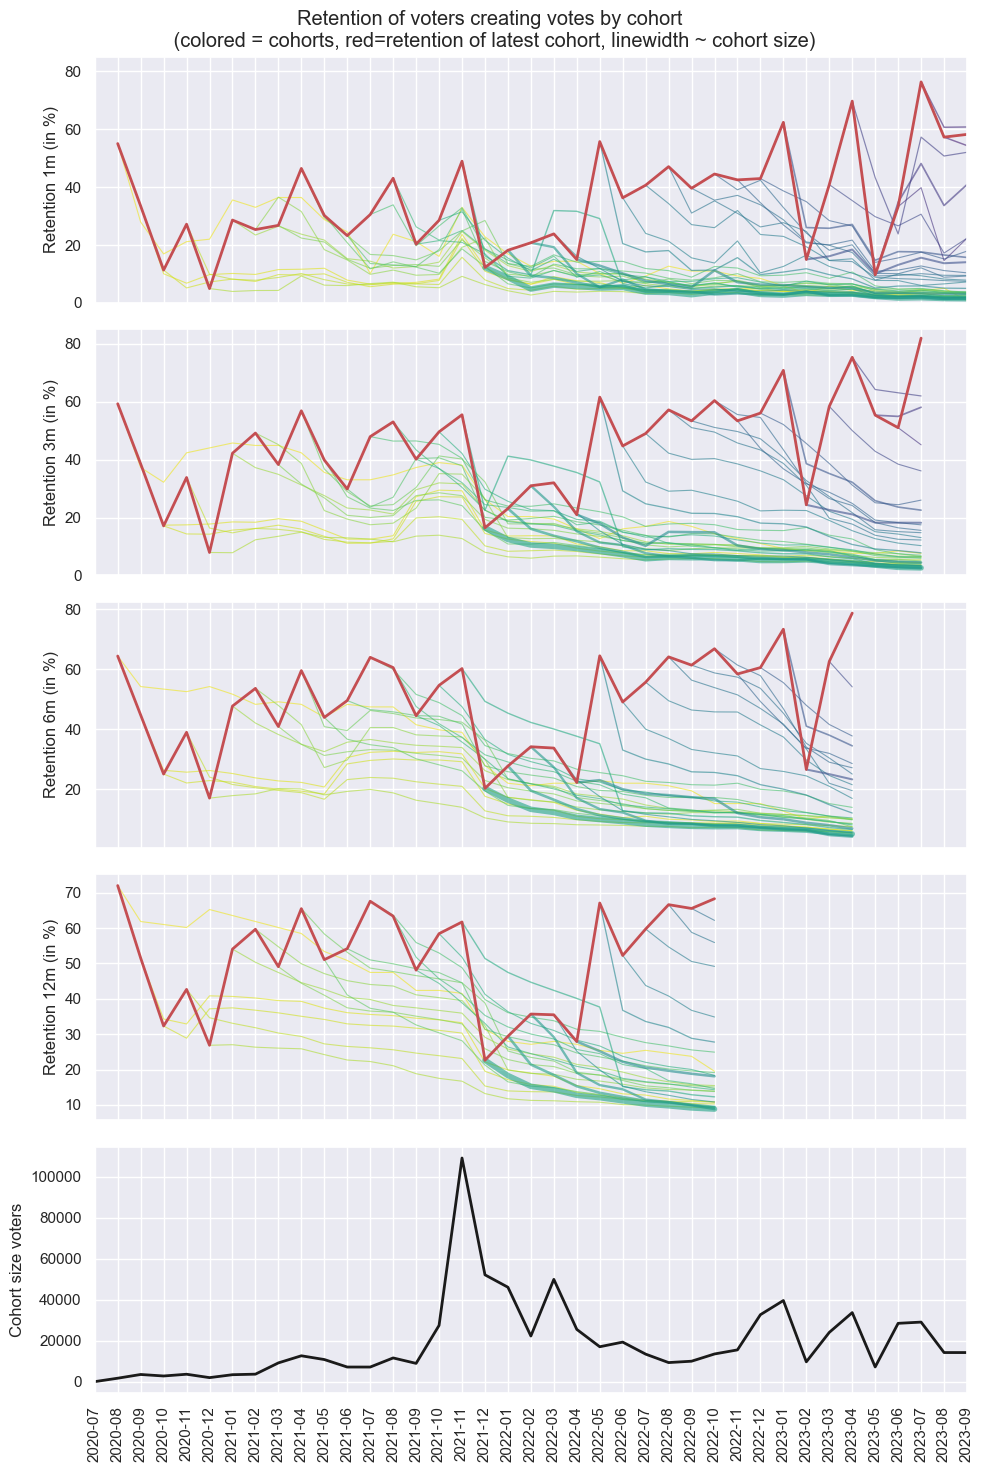

In [116]:
make_retention_chart(df_retention_voters_verified,list_cohorts_voters_verified,lst_cohort_size_voters_verified,retention_lst,'voters','votes',ylim=85,ignore_last=True)

In [ ]:
[list_cohorts_voters_unflagged,lst_cohort_size_voters_unflagged,df_retention_voters_unflagged] = create_retention_df(df_votes_target_unflagged,grp_col = 'voter',cohort_col='first_proposal')
retention_lst = [1,3,6,12]

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


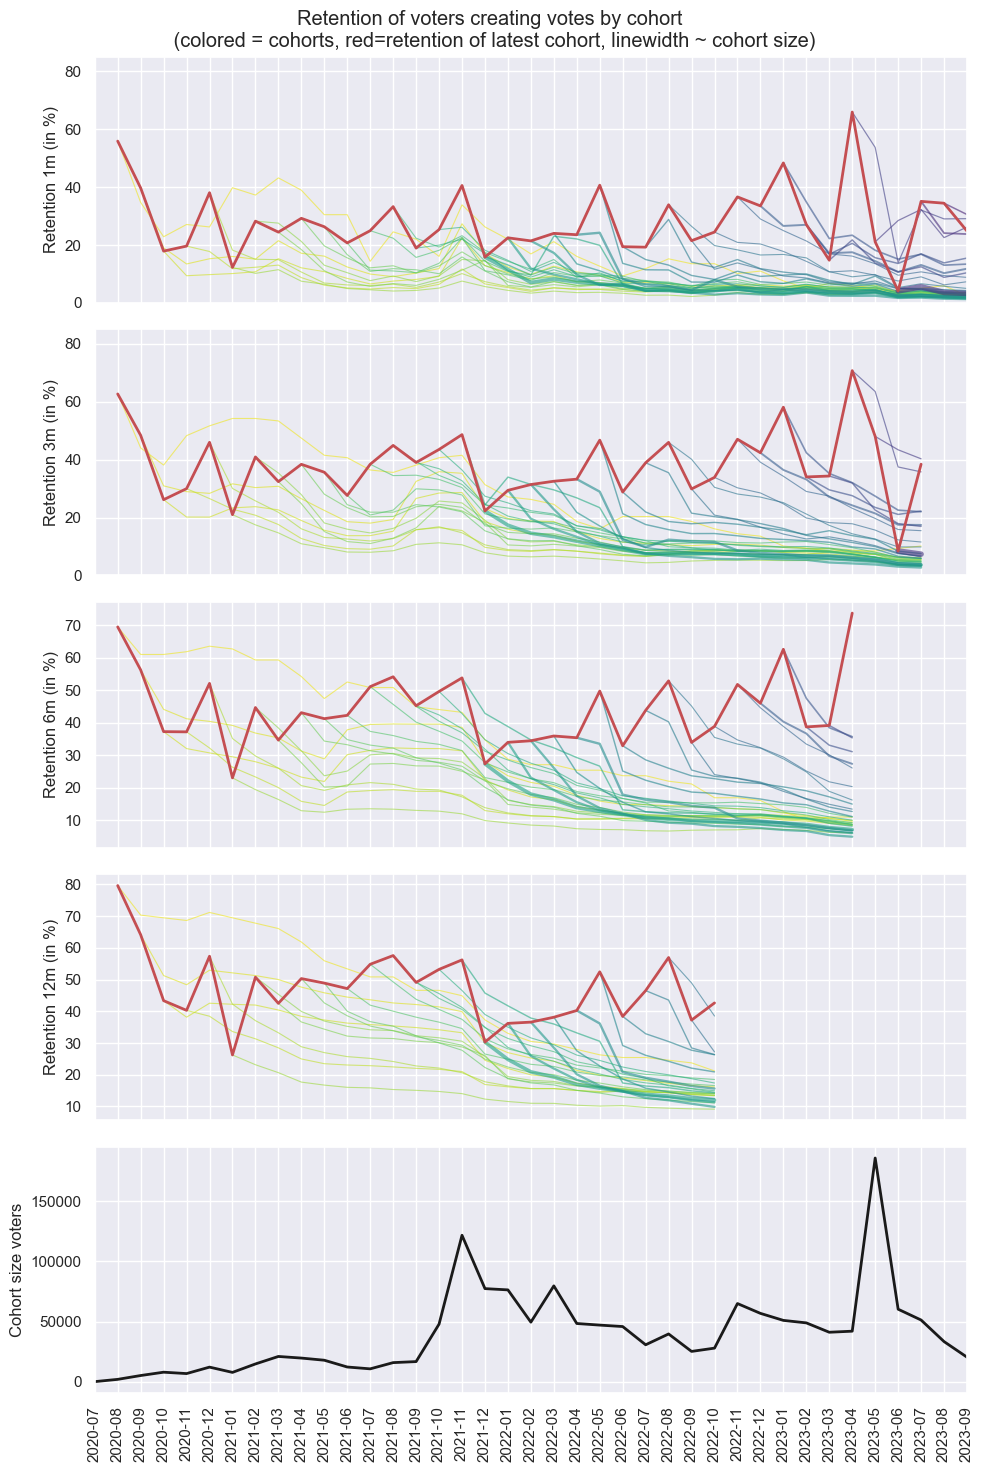

In [117]:
make_retention_chart(df_retention_voters_unflagged,list_cohorts_voters_unflagged,lst_cohort_size_voters_unflagged,retention_lst,'voters','votes',ylim=85,ignore_last=True)

In [ ]:
[list_cohorts_users_proposals_verified,lst_cohort_size_users_proposals_verified,df_retention_users_proposals_verified] = create_retention_df(df_proposals_created_verified,grp_col = 'author',cohort_col='first_proposal')
retention_lst = [1,3,6,12]

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


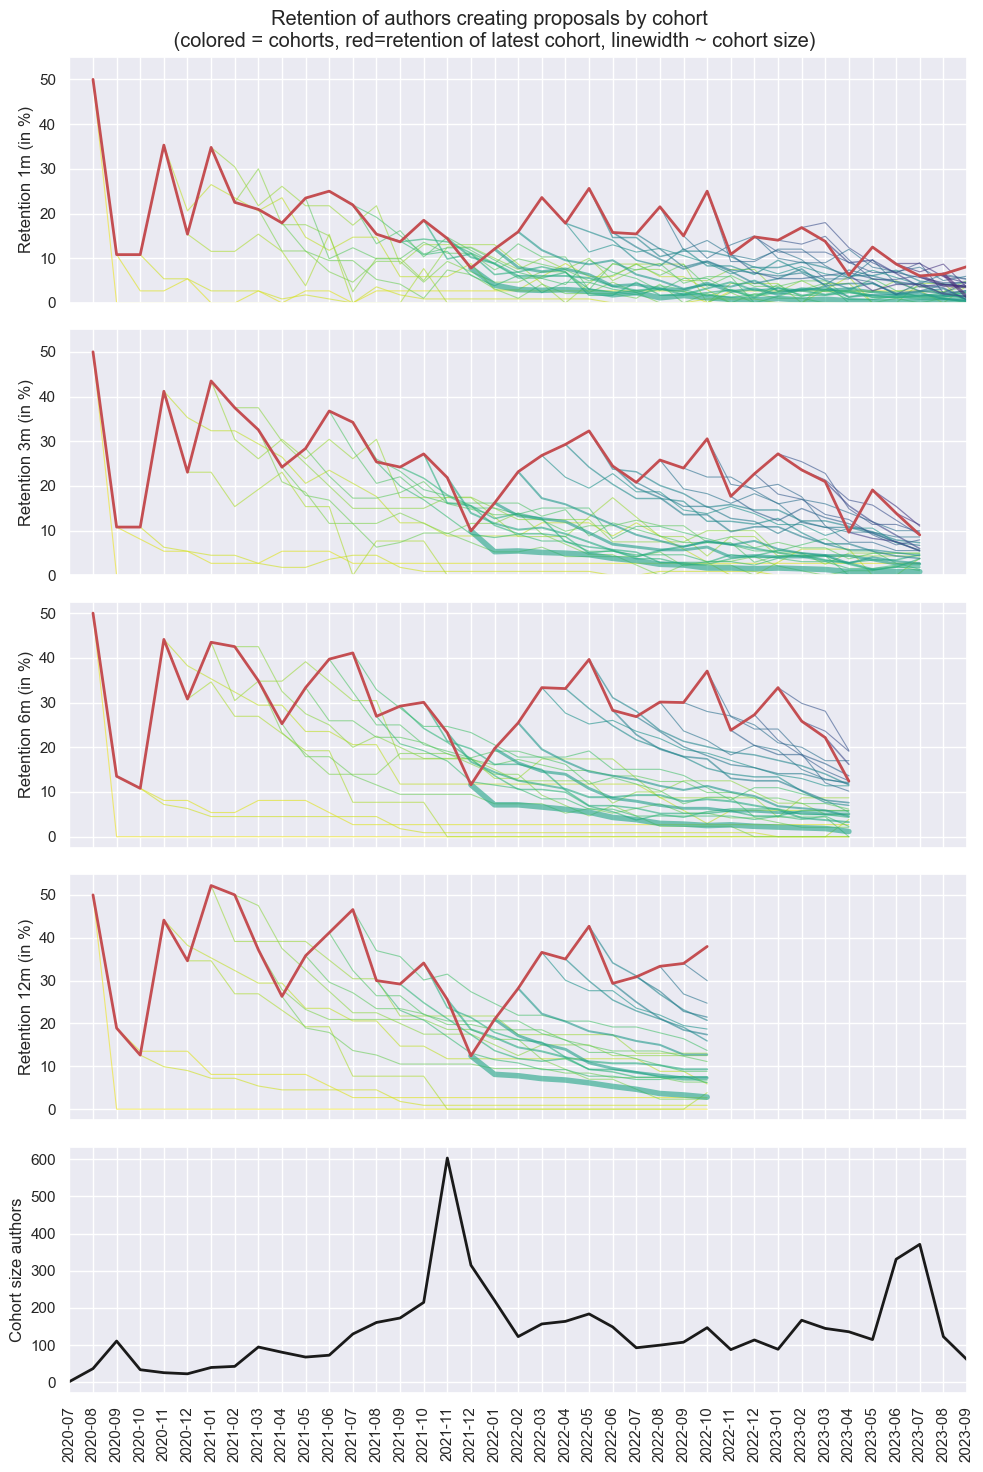

In [118]:
make_retention_chart(df_retention_users_proposals_verified,list_cohorts_users_proposals_verified,lst_cohort_size_users_proposals_verified,retention_lst,'authors','proposals',ylim=55,ignore_last=True)

In [ ]:
[list_cohorts_users_proposals_unflagged,lst_cohort_size_users_proposals_unflagged,df_retention_users_proposals_unflagged] = create_retention_df(df_proposals_created_unflagged,grp_col = 'author',cohort_col='first_proposal')
retention_lst = [1,3,6,12]

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


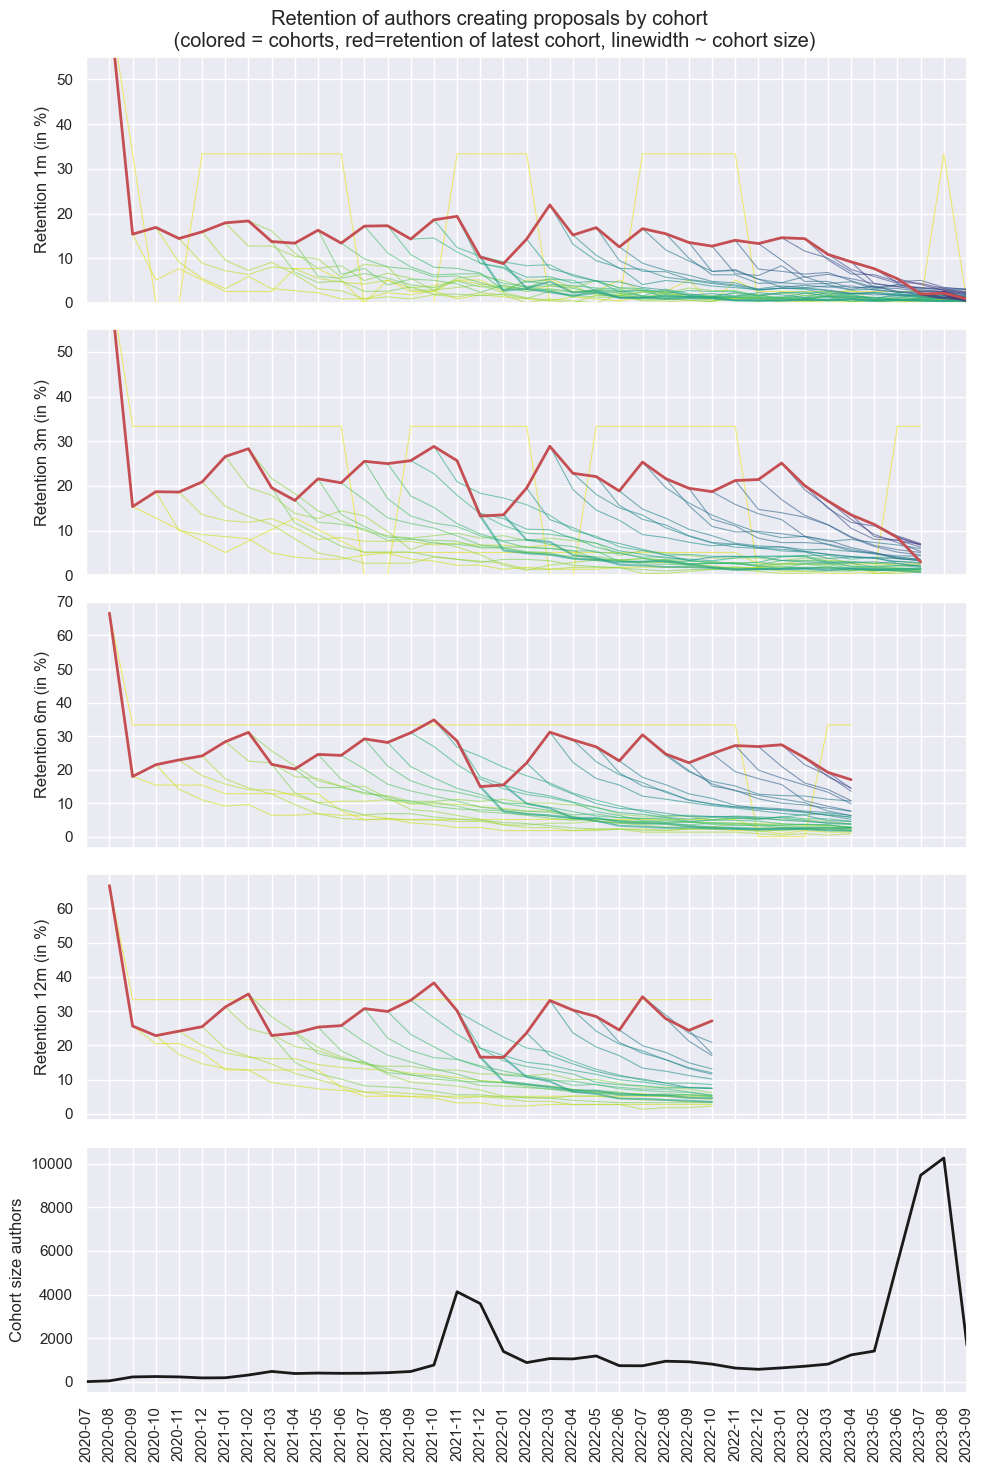

In [119]:
make_retention_chart(df_retention_users_proposals_unflagged,list_cohorts_users_proposals_unflagged,lst_cohort_size_users_proposals_unflagged,retention_lst,'authors','proposals',ylim=55,ignore_last=True)

In [ ]:
[list_cohorts_spaces_proposals_verified,lst_cohort_size_spaces_proposals_verified,df_retention_spaces_proposals_verified] = create_retention_df(df_proposals_created_verified,grp_col = 'space',cohort_col='first_proposal')
retention_lst = [1,3,6,12]

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


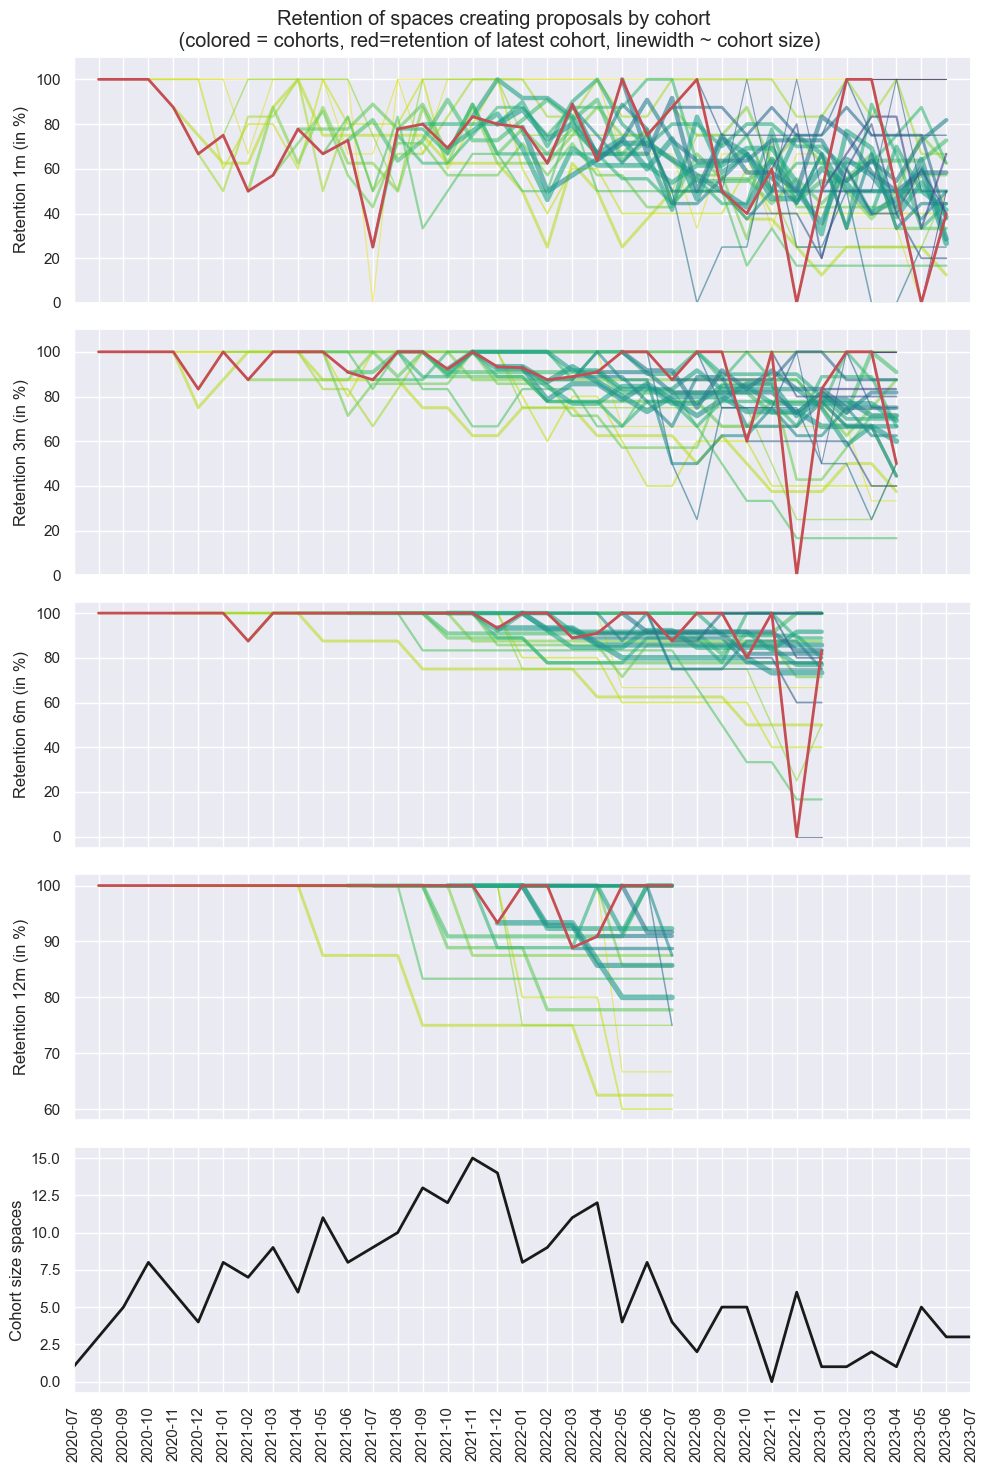

In [121]:
make_retention_chart(df_retention_spaces_proposals_verified,list_cohorts_spaces_proposals_verified,lst_cohort_size_spaces_proposals_verified,retention_lst,'spaces','proposals',ylim=110,ignore_last=False)

In [ ]:
[list_cohorts_spaces_proposals_unflagged,lst_cohort_size_spaces_proposal_unflagged,df_retention_spaces_proposals_unflagged] = create_retention_df(df_proposals_created_unflagged,grp_col = 'space',cohort_col='first_proposal')
retention_lst = [1,3,6,12]

/var/folders/md/vvms6sc52q347dj43s7k00j40000gn/T/ipykernel_2965/524400145.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[4].set_xticklabels(df_data['year_month'], rotation=90)


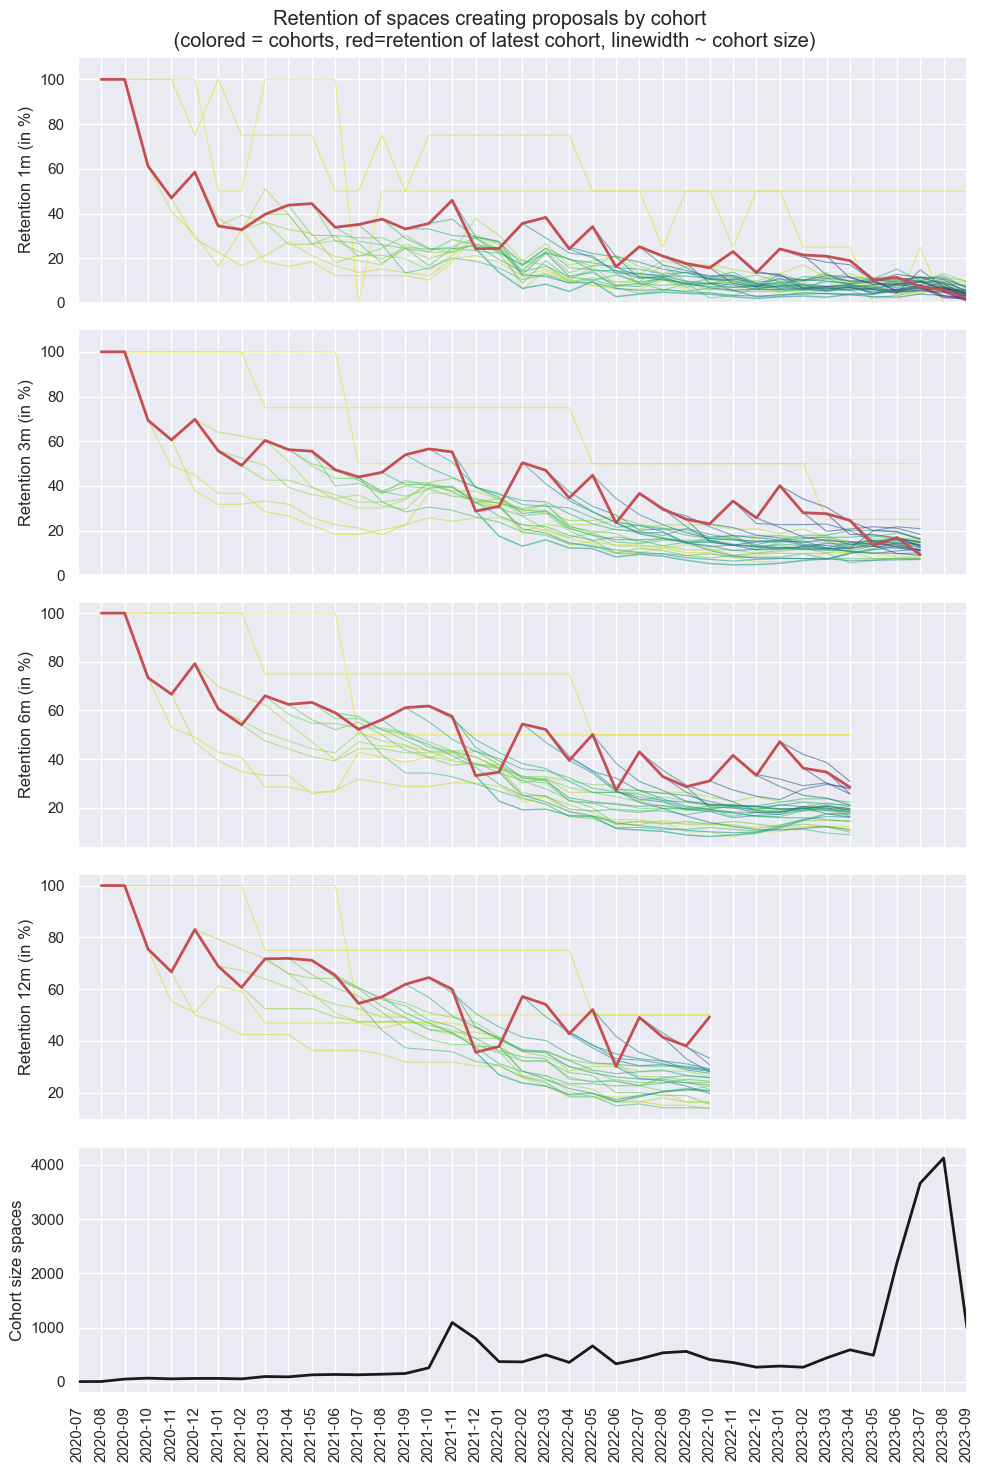

In [122]:
make_retention_chart(df_retention_spaces_proposals_unflagged,list_cohorts_spaces_proposals_unflagged,lst_cohort_size_spaces_proposal_unflagged,retention_lst,'spaces','proposals',ylim=110,ignore_last=True)